South


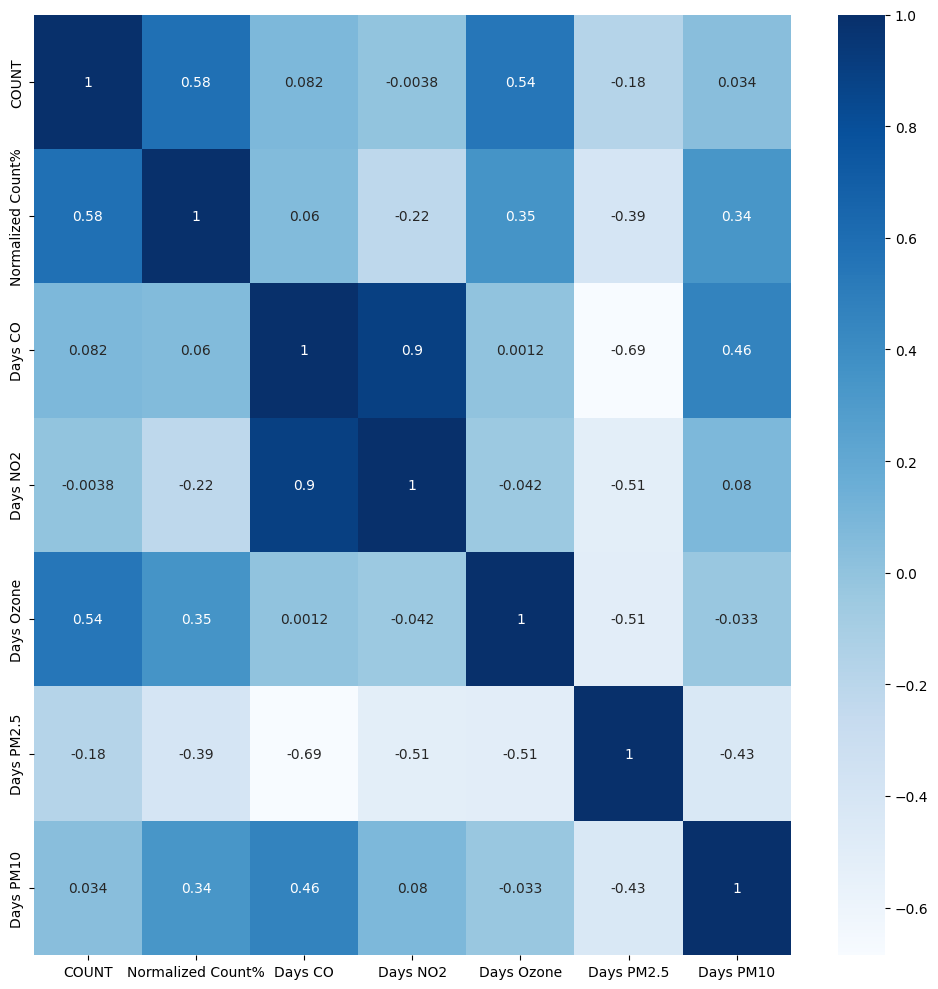

Alaska and Hawaii


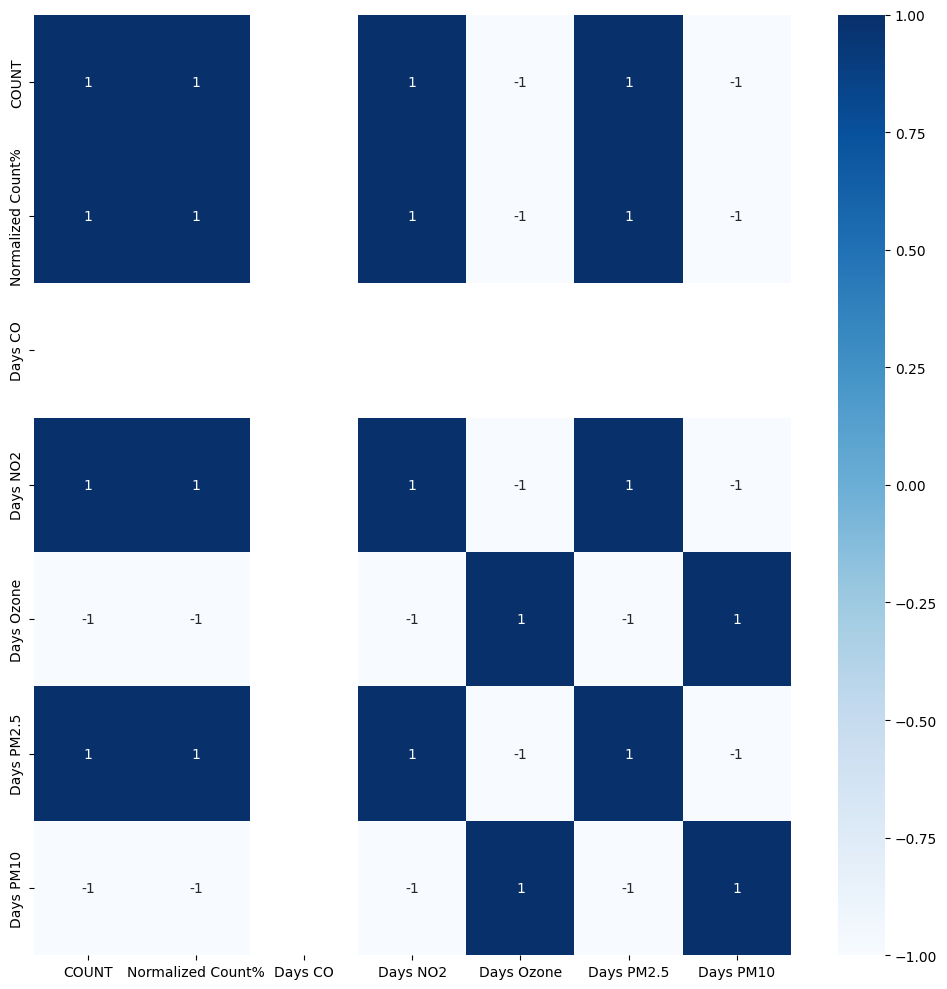

Southwest


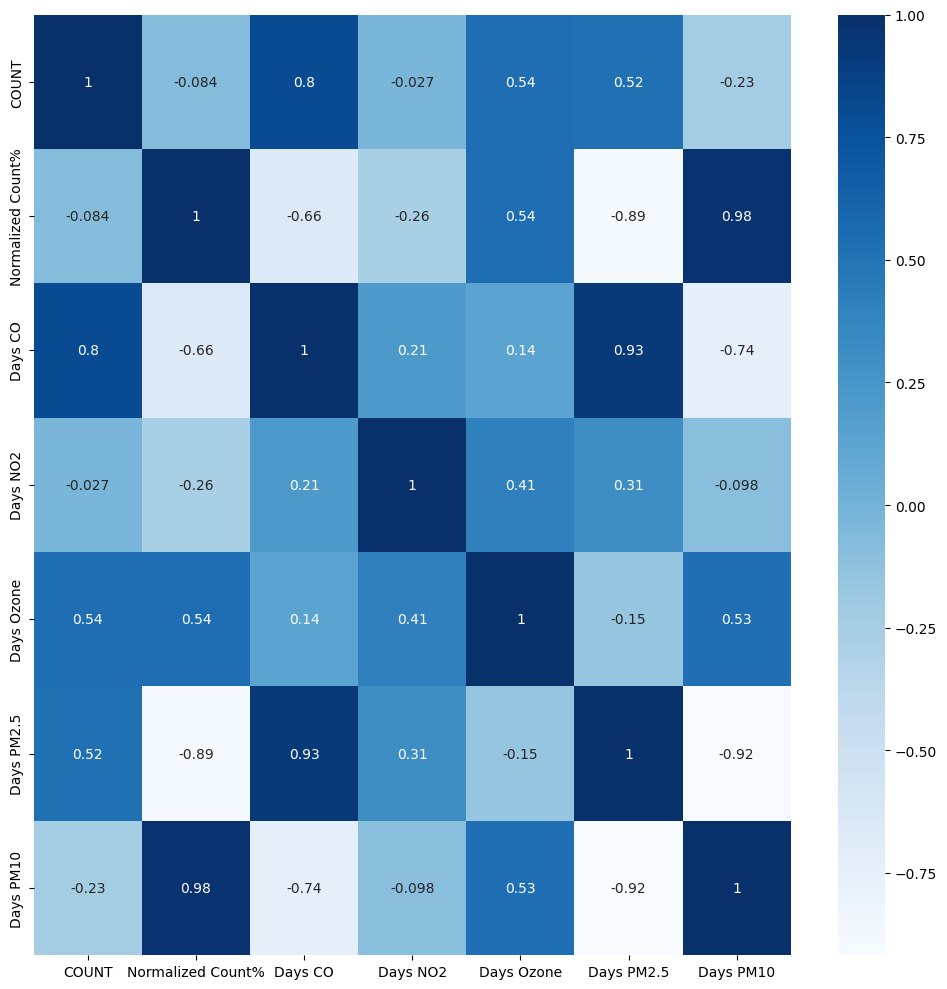

West Coast


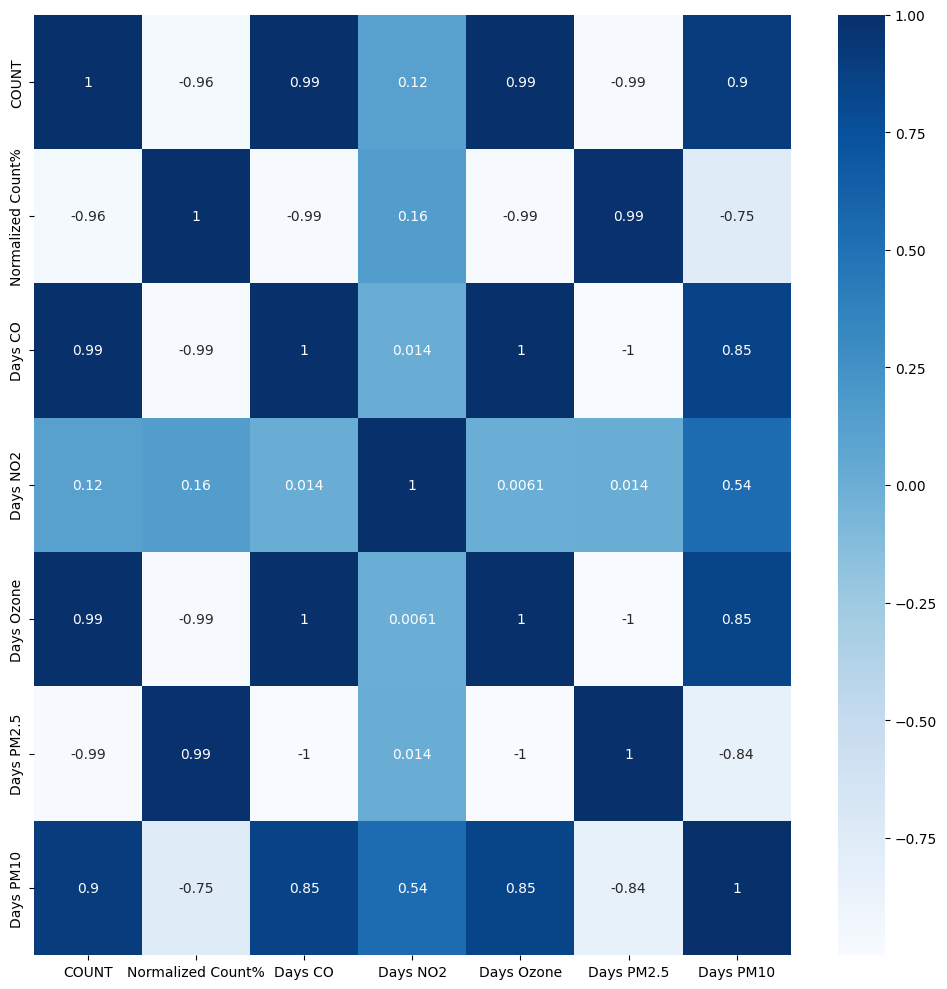

Rocky Mountains


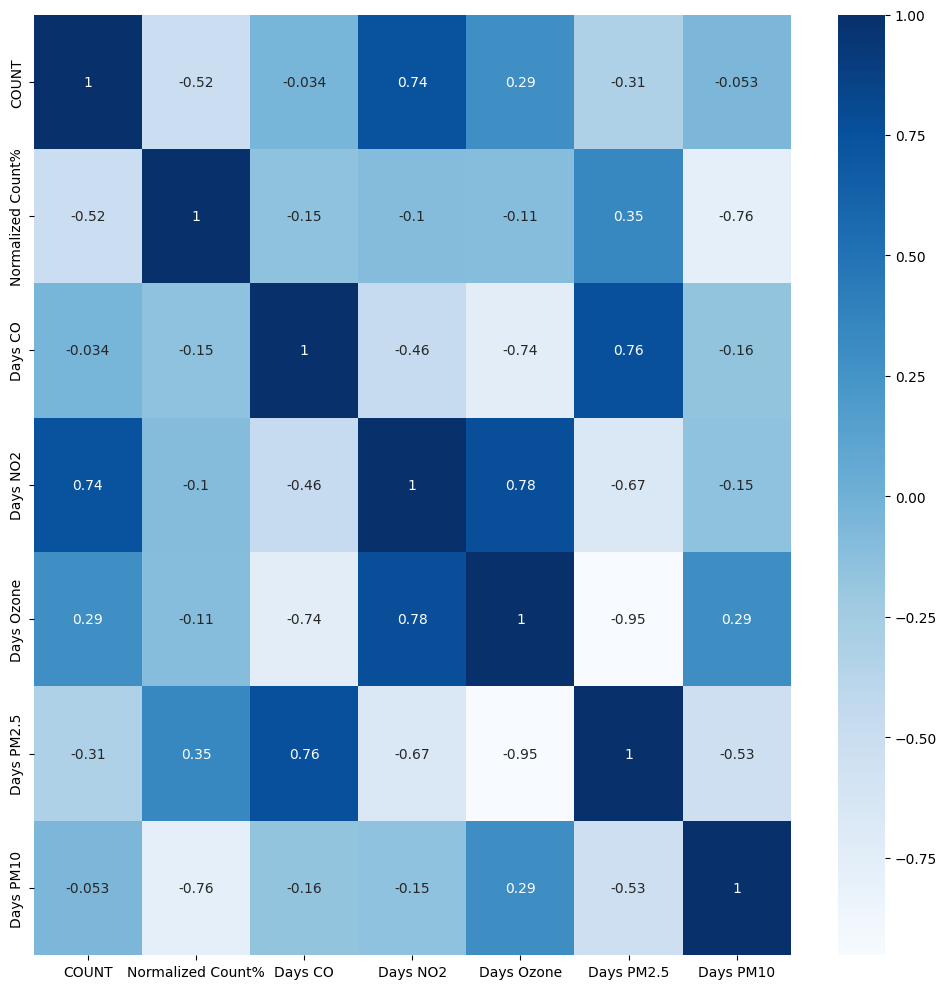

New England


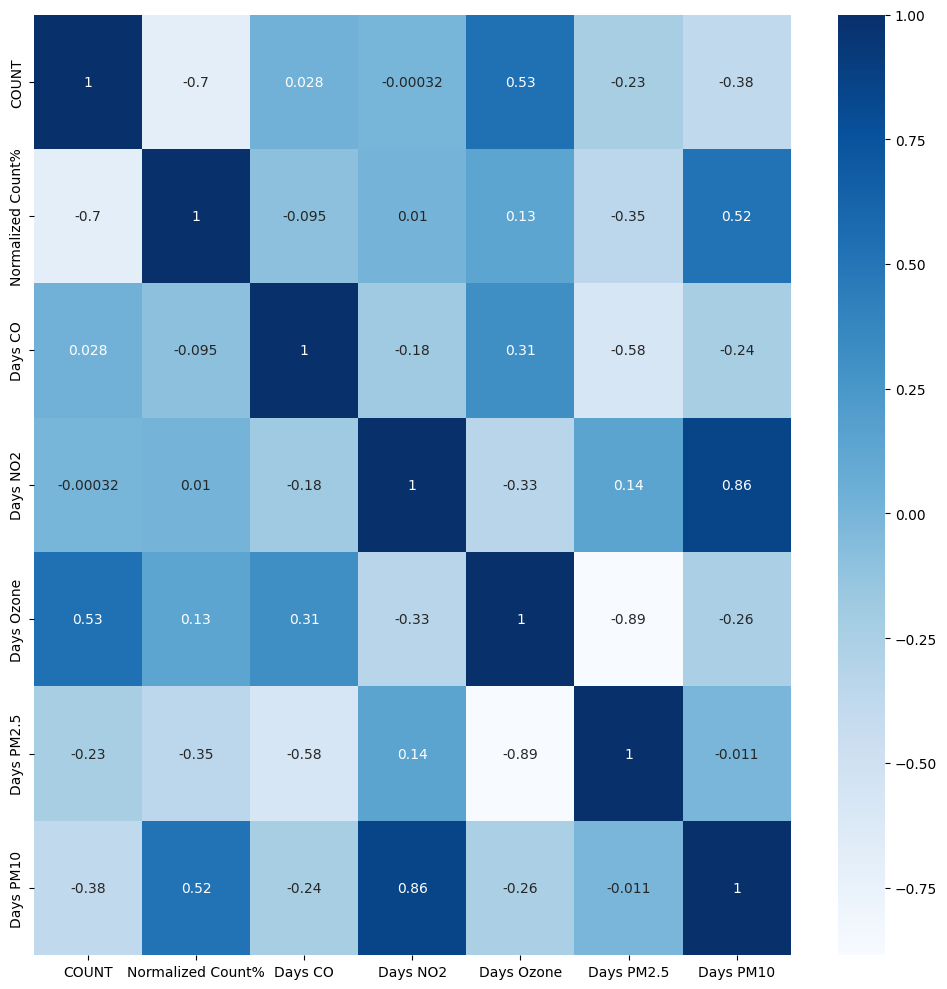

Mid-Atlantic


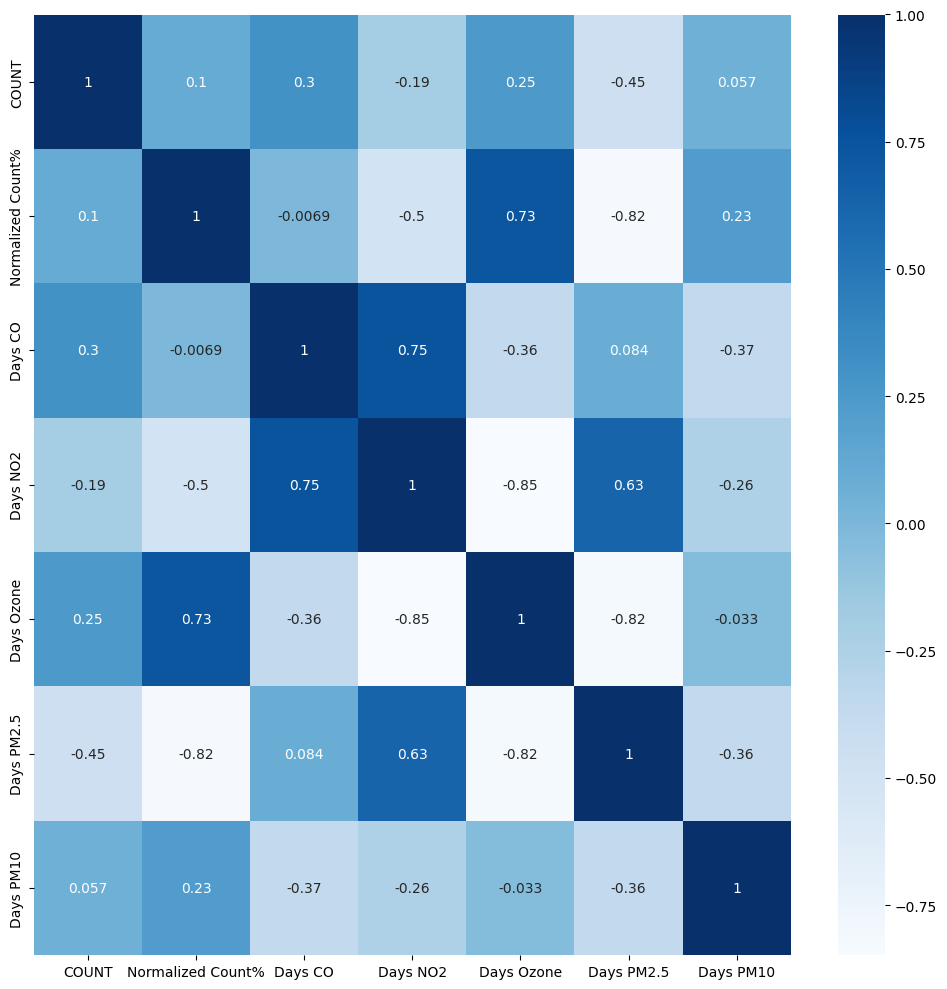

Midwest


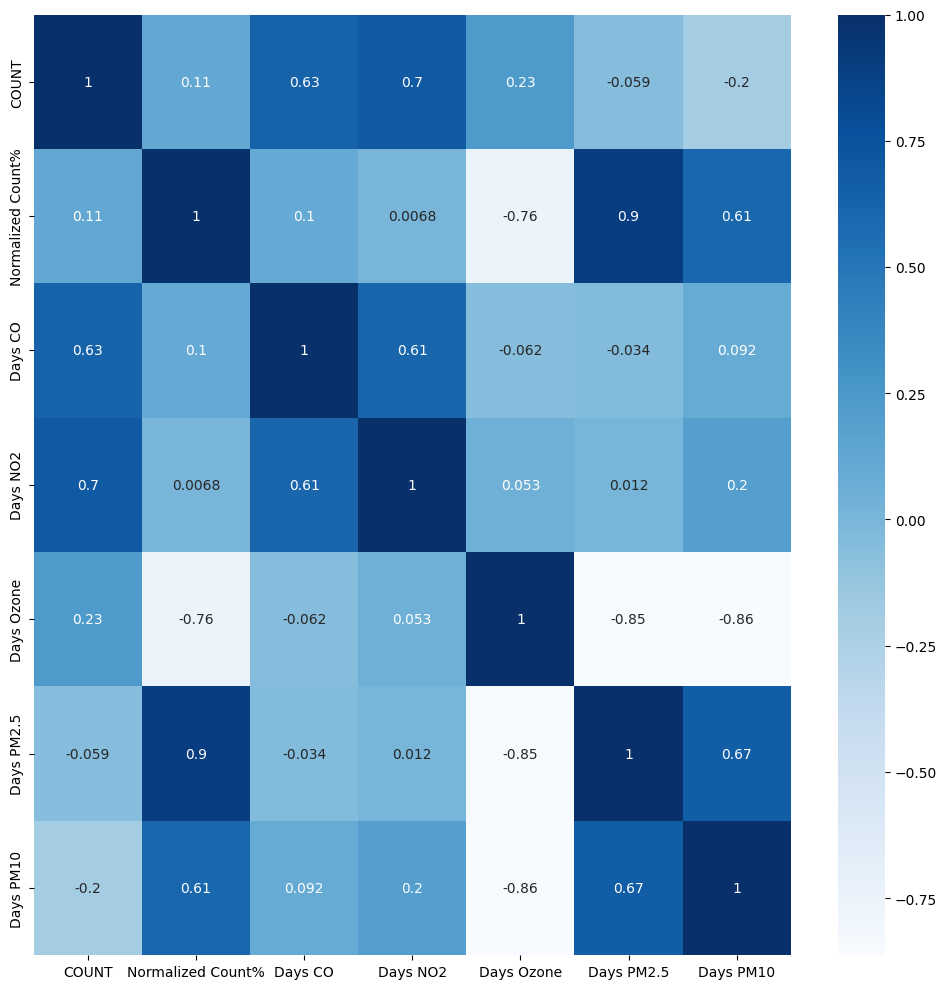

Great Plains


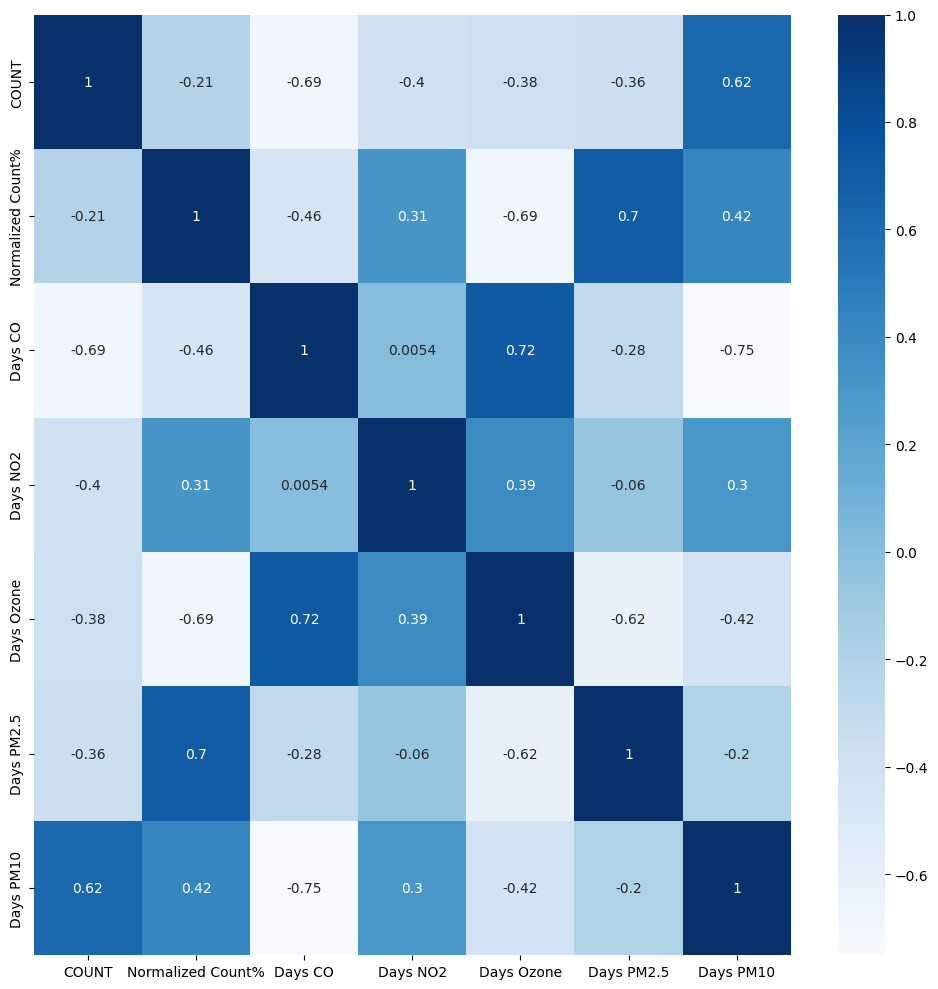

In [43]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution = '/kaggle/input/annual-aqi-by-county-2018/annual_aqi_by_county_2018.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2018'
#site_csv = 'df_cancer_airpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000

##########################################################

########################################################
#STEP 1 - Create Air pollution dataset for USA states
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new)

########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']
df_all = pd.merge(df_cancer_population_count, air_pollution_df_new, on='AREA', how='inner')

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
# df_region_cancer = df_all.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
# print(df_region_cancer.columns)
# matrix_normalized_test = df_region_cancer.corr()
# plt.rcParams["figure.figsize"] = [15, 25]
# plt.rcParams["figure.autolayout"] = True
# fig, (ax1) = plt.subplots(ncols=1)
# fig.subplots_adjust(wspace=0.05)
# sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
# ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
# ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
# fig.subplots_adjust(wspace=0.005)
# plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region.columns)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    #print (df_region.columns)
    print (region)
    #print (df_region)
    #df_region_cancer = df_region.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
    df_region_cancer = df_region.iloc[:, [1,3,10,11,12,13,14]]
    #print(df_region_cancer.columns)
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    #ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    #ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

South


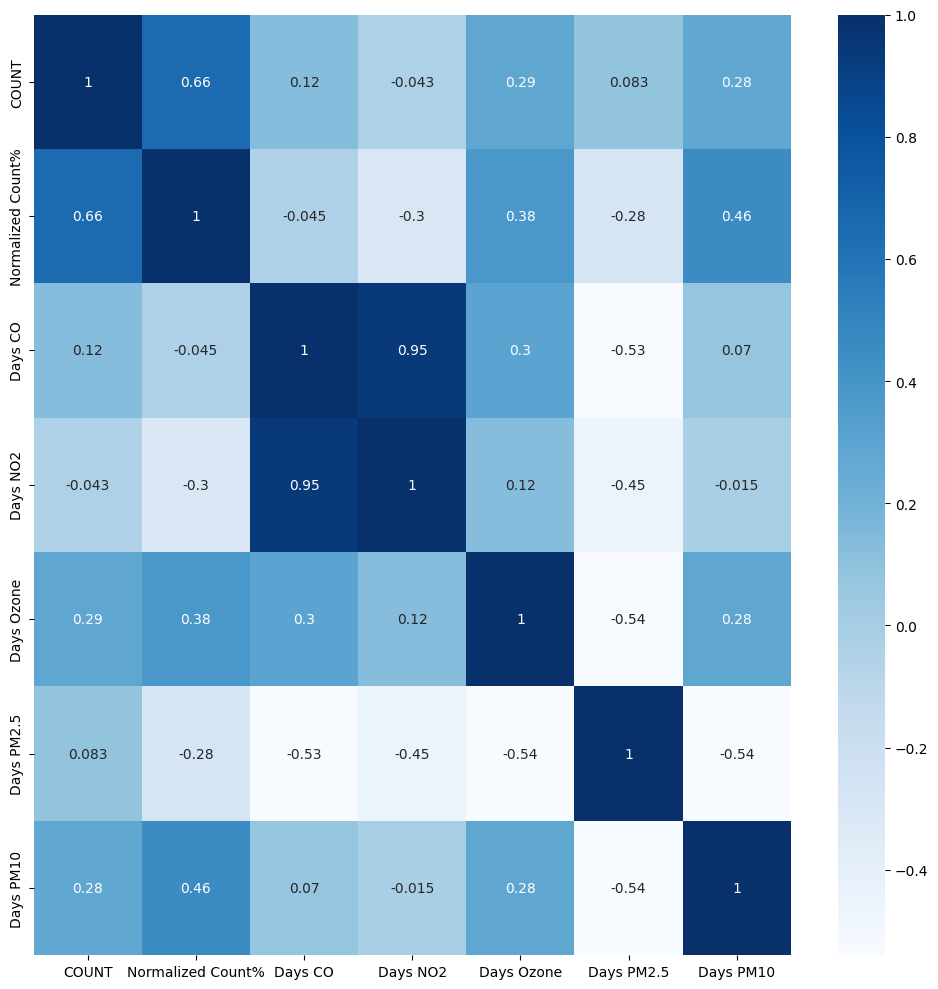

Alaska and Hawaii


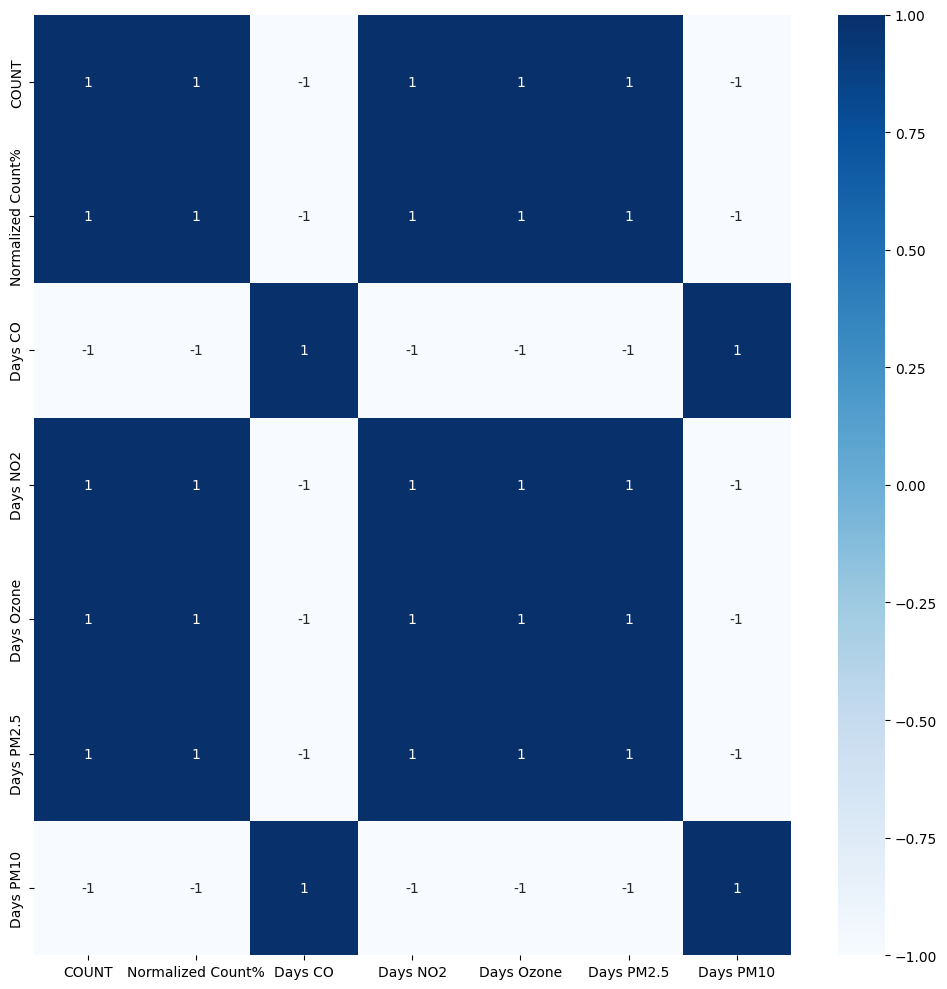

Southwest


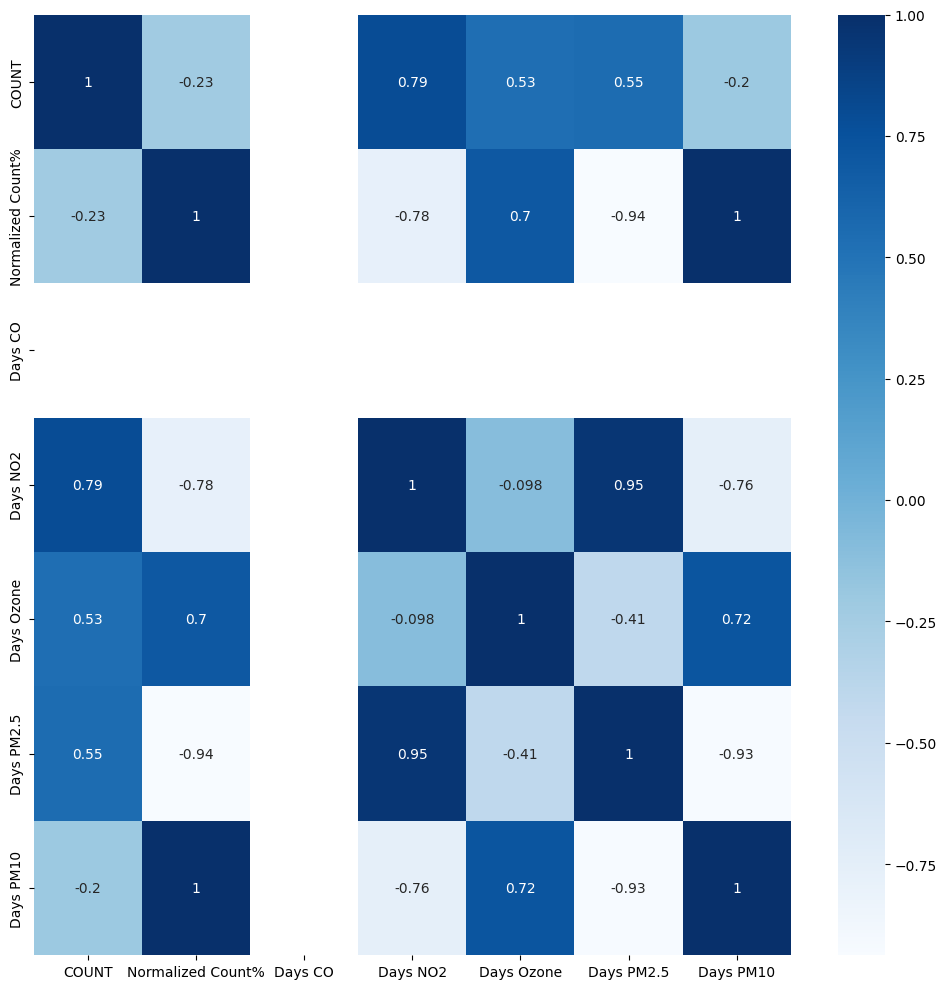

West Coast


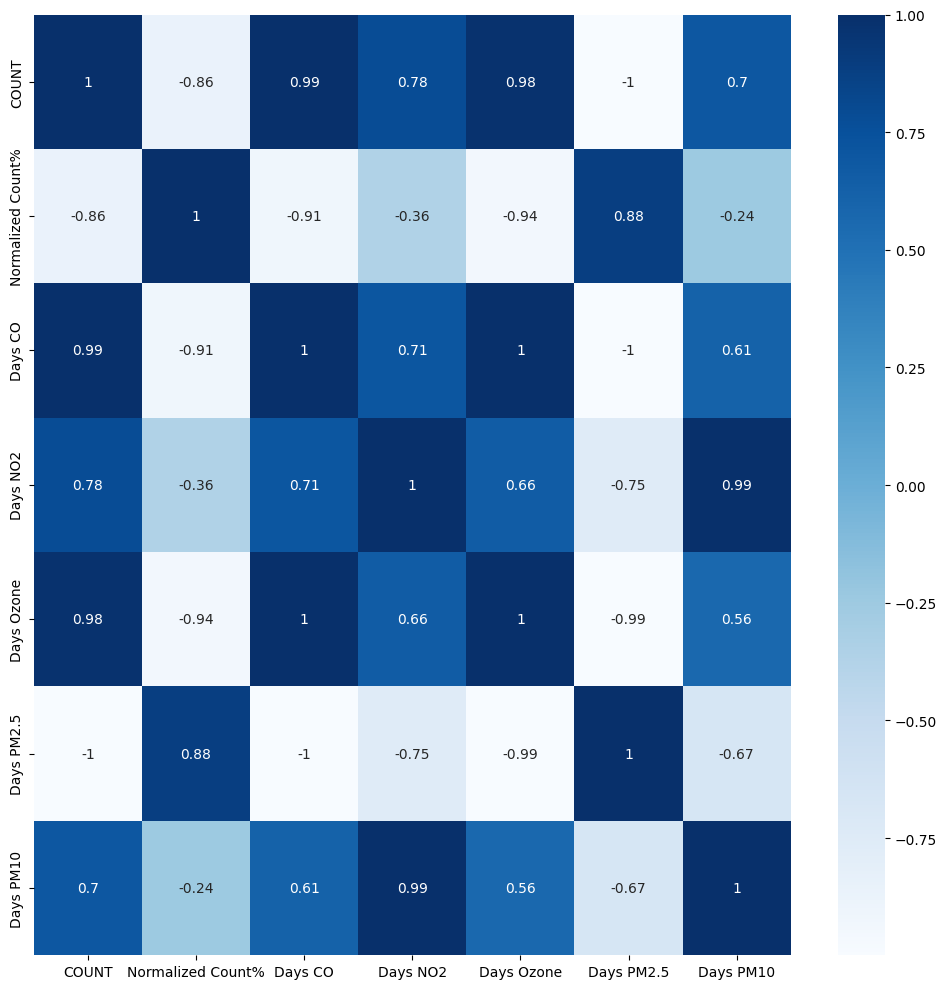

Rocky Mountains


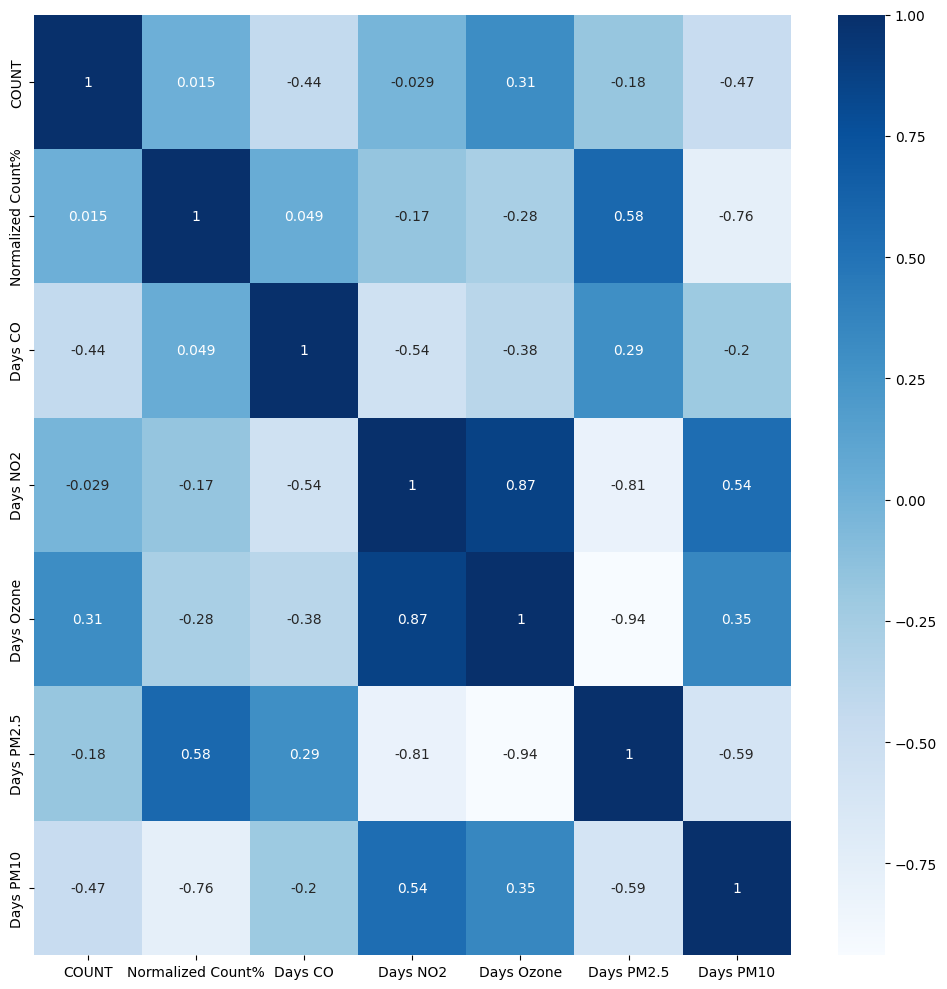

New England


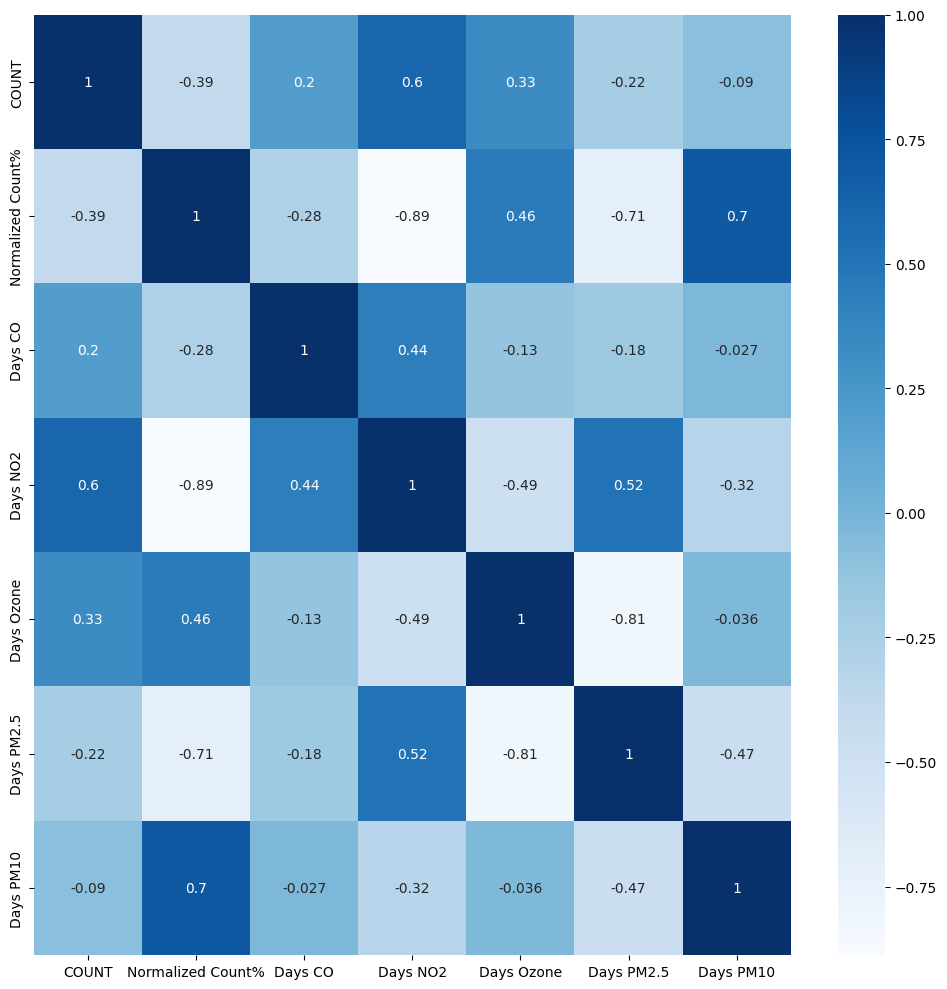

Mid-Atlantic


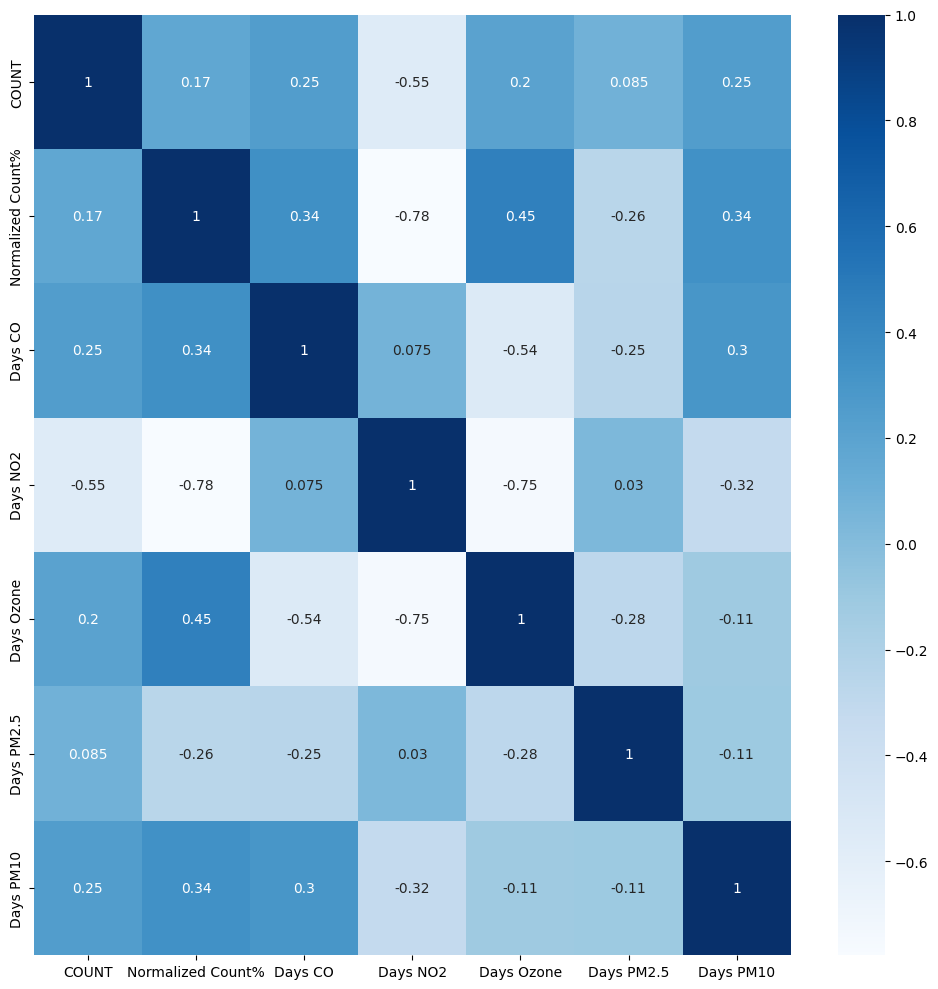

Midwest


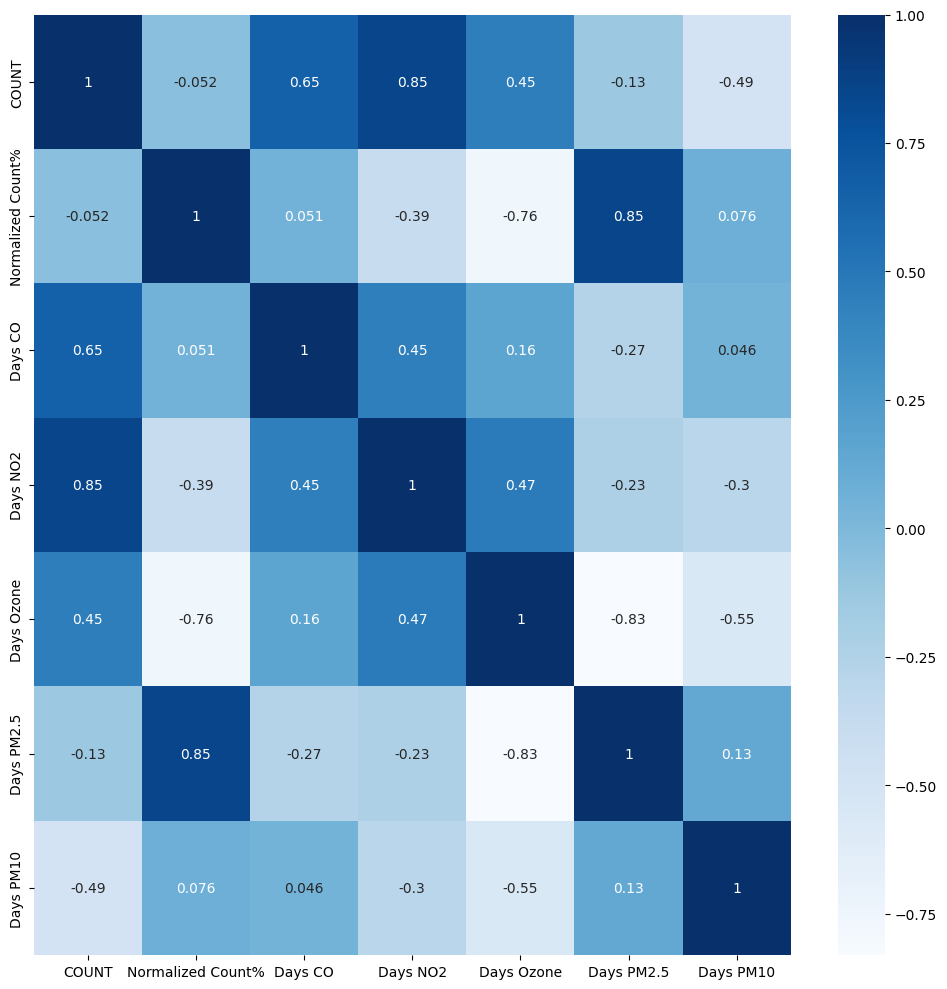

Great Plains


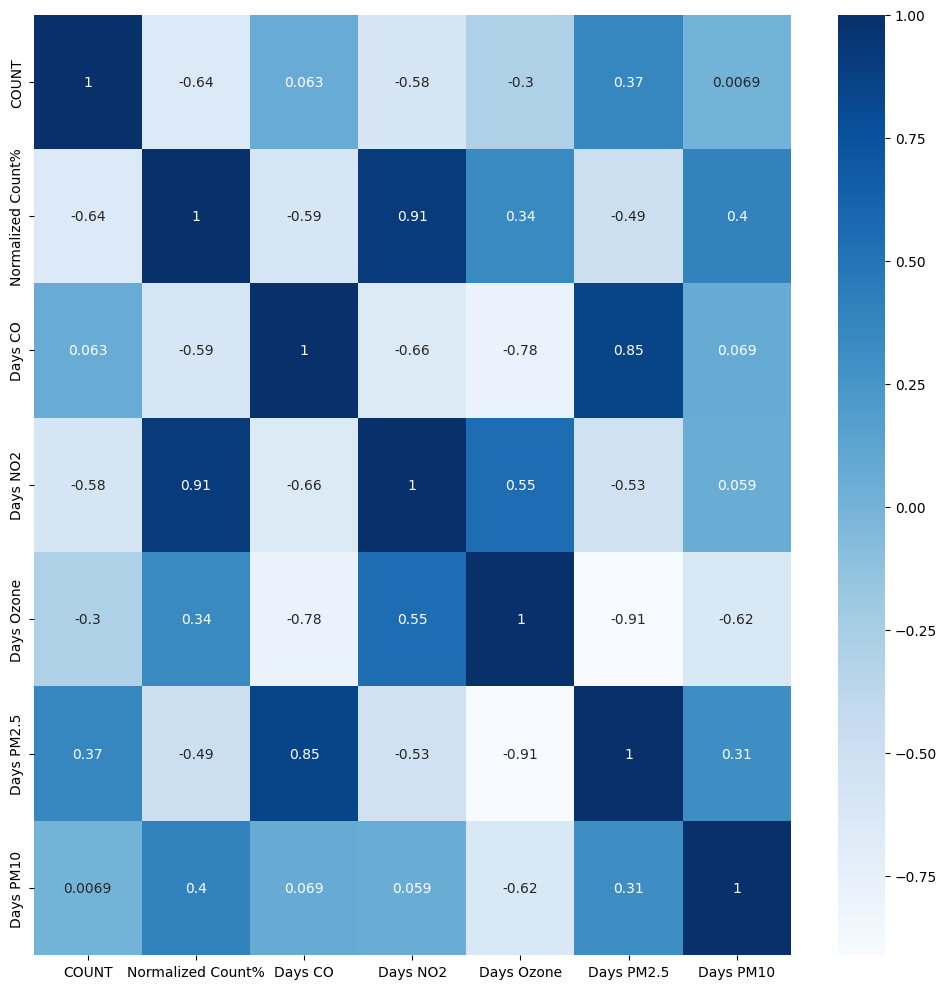

In [42]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution = '/kaggle/input/annual-aqi-by-county-2020/annual_aqi_by_county_2020.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2020'
#site_csv = 'df_cancer_airpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000

##########################################################

########################################################
#STEP 1 - Create Air pollution dataset for USA states
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new)

########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']
df_all = pd.merge(df_cancer_population_count, air_pollution_df_new, on='AREA', how='inner')

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
# df_region_cancer = df_all.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
# print(df_region_cancer.columns)
# matrix_normalized_test = df_region_cancer.corr()
# plt.rcParams["figure.figsize"] = [15, 25]
# plt.rcParams["figure.autolayout"] = True
# fig, (ax1) = plt.subplots(ncols=1)
# fig.subplots_adjust(wspace=0.05)
# sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
# ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
# ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
# fig.subplots_adjust(wspace=0.005)
# plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
#print(df_cancercount_region.columns)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    #print (df_region.columns)
    print (region)
    #df_region_cancer = df_region.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
    df_region_cancer = df_region.iloc[:, [1,3,10,11,12,13,14]]
    #print(df_region_cancer.columns)
    matrix_normalized_test = df_region_cancer.corr()
    #plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    #ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    #ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

In [1]:
#Create datasets for plotting graphs for paper - 2019  All cancer and all air pollution types

#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution = '/kaggle/input/annual-aqi-by-county-2019/annual_aqi_by_county_2019.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2019'
#site_csv = 'df_cancer_airpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000

##########################################################

########################################################
#STEP 1 - Create Air pollution dataset for USA states
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new)

########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']
df_all = pd.merge(df_cancer_population_count, air_pollution_df_new, on='AREA', how='inner')

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
print(df_cancercount_region.columns)
print(df_cancercount_region.head(1))

df_cancercount_region.to_csv('regional_air_pollution_cancer_data_2019.csv')

Index(['AREA', 'COUNT', 'POPULATION', 'Normalized Count%', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', 'Days CO',
       'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'Region '],
      dtype='object')
      AREA  COUNT  POPULATION  Normalized Count%  Moderate Days  \
0  Alabama   1215     4907965           2.475568      60.235294   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
0                                  1.0             0.0                  0.0   

   Hazardous Days    Max AQI  Days CO  Days NO2  Days Ozone  Days PM2.5  \
0             0.0  88.823529      0.0  0.117647  164.470588  125.117647   

   Days PM10 Region   
0   0.529412   South  


                    AREA  COUNT  POPULATION  Normalized Count%  Moderate Days  \
0                Alabama   1215     4907965           2.475568      60.235294   
1                 Alaska    114      733603           1.553974      32.777778   
2                Arizona   2742     7291843           3.760366      99.692308   
3               Arkansas    981     3020985           3.247285      39.461538   
4             California  10474    39437610           2.655840      95.339623   
5               Colorado   1383     5758486           2.401673      64.000000   
6            Connecticut    890     3566022           2.495778      40.875000   
7               Delaware    366      976668           3.747435      80.333333   
8   District of Columbia     64      708253           0.903632     118.000000   
9                Florida   7749    21492056           3.605518      39.871795   
10               Georgia   2996    10628020           2.818963      66.862069   
11                Hawaii    

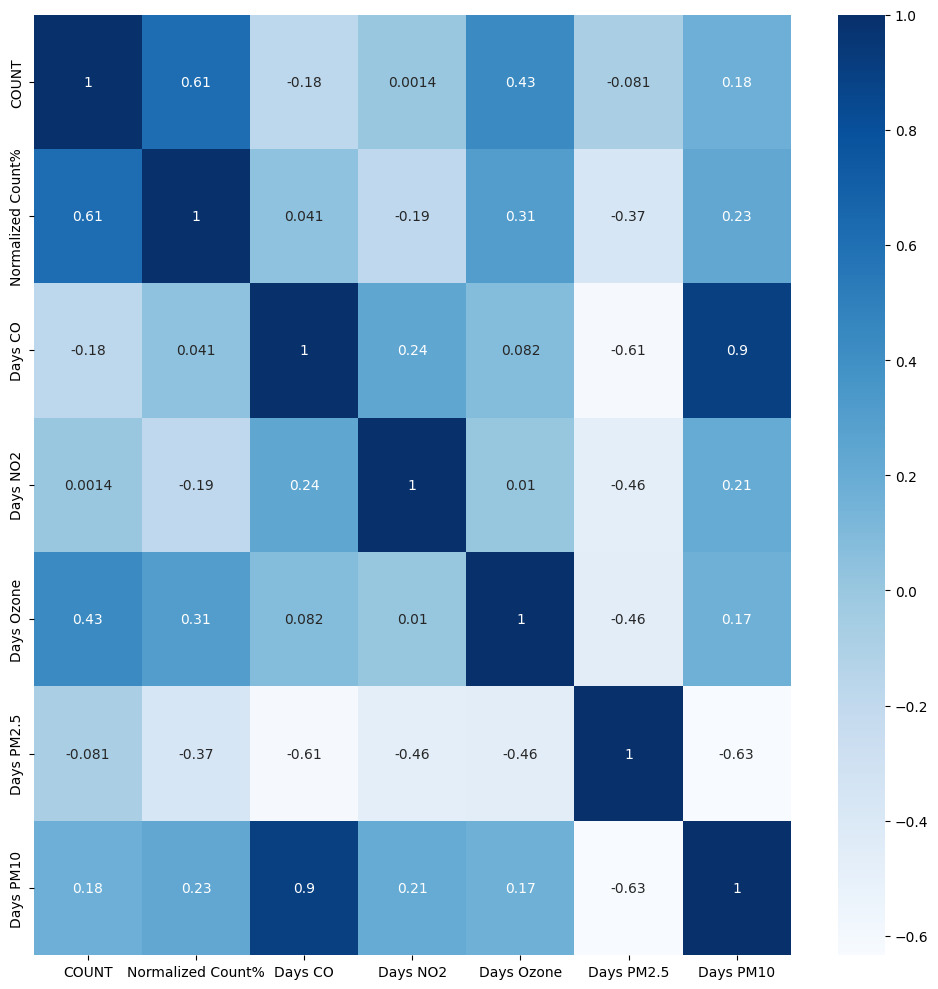

Alaska and Hawaii


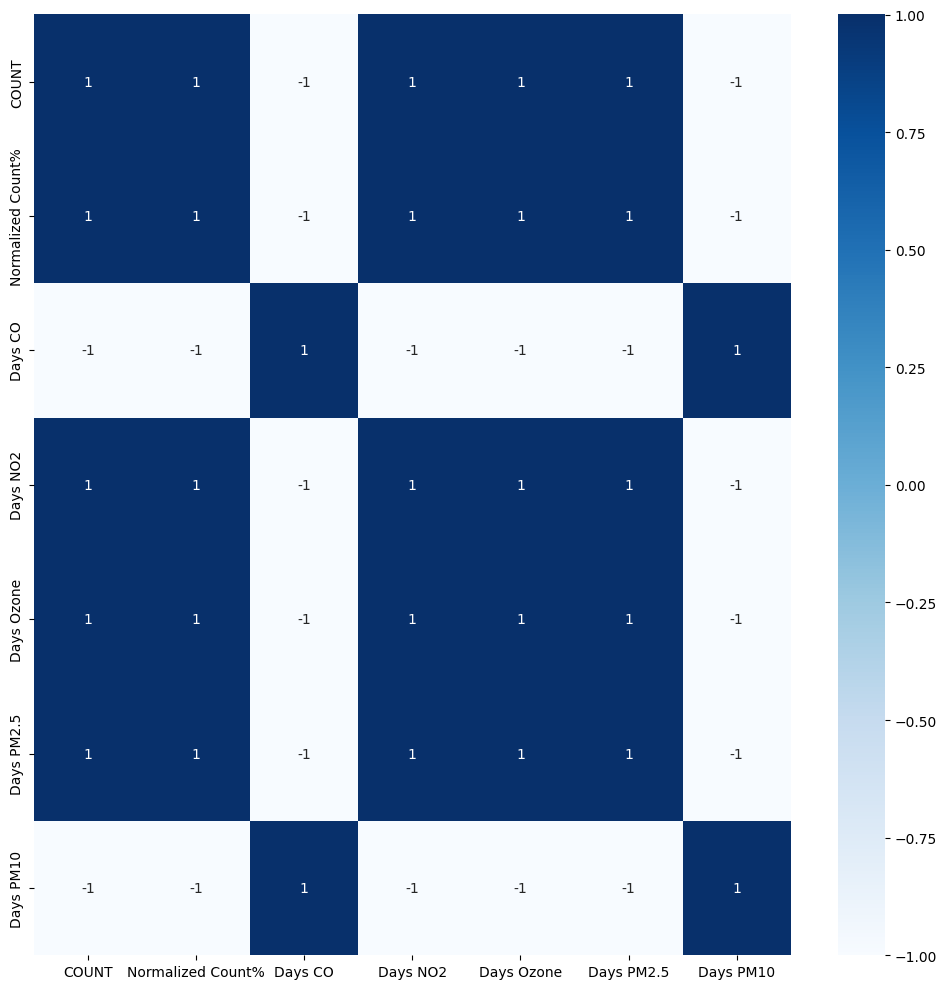

Southwest


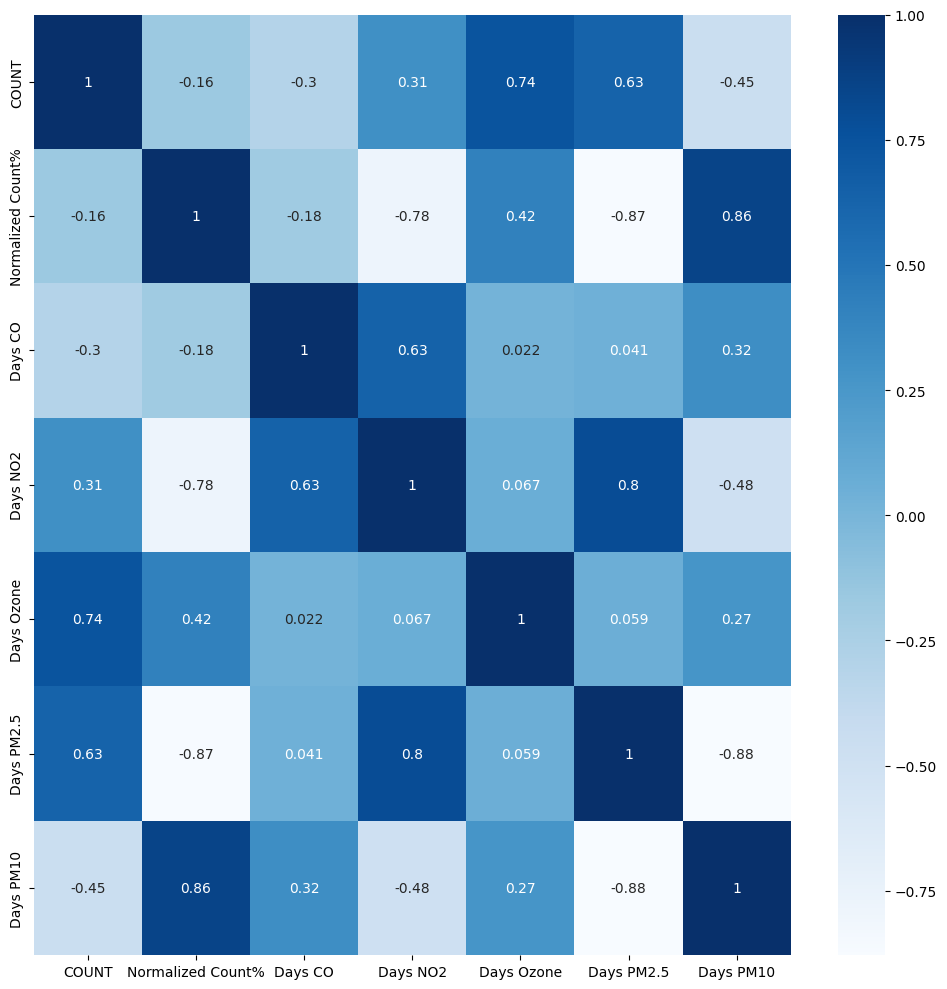

West Coast


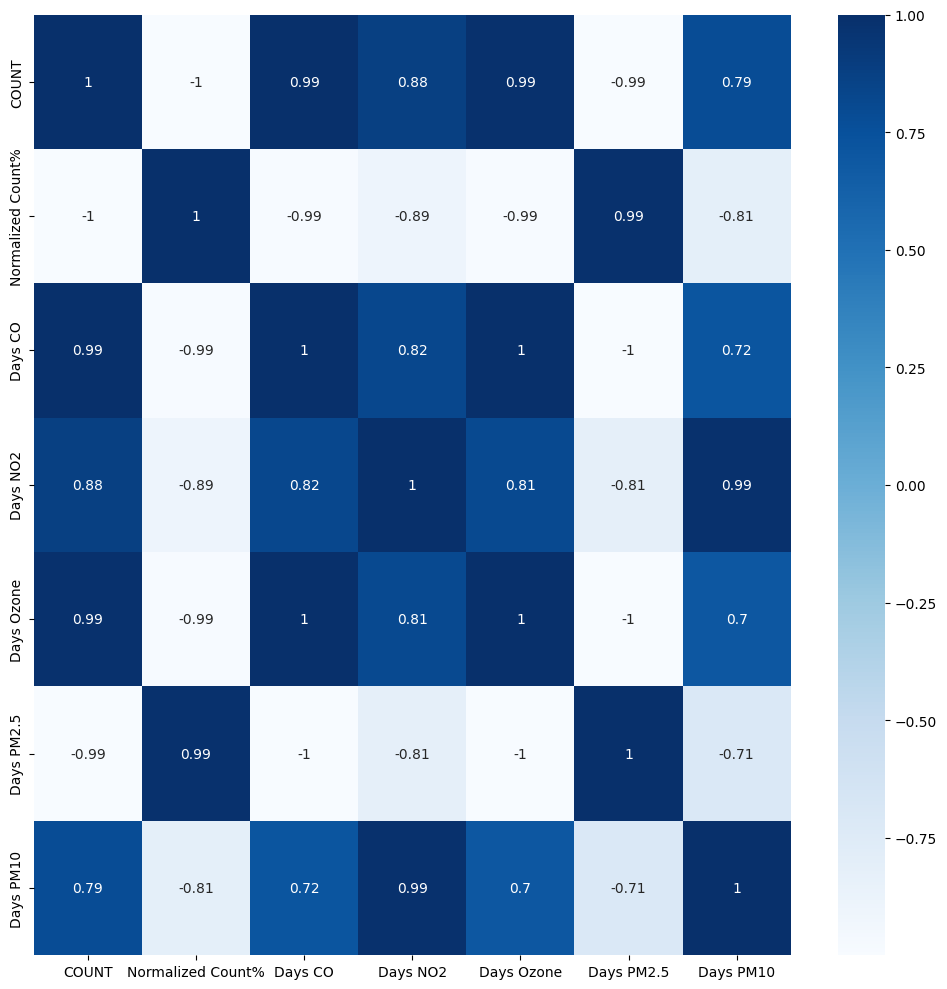

Rocky Mountains


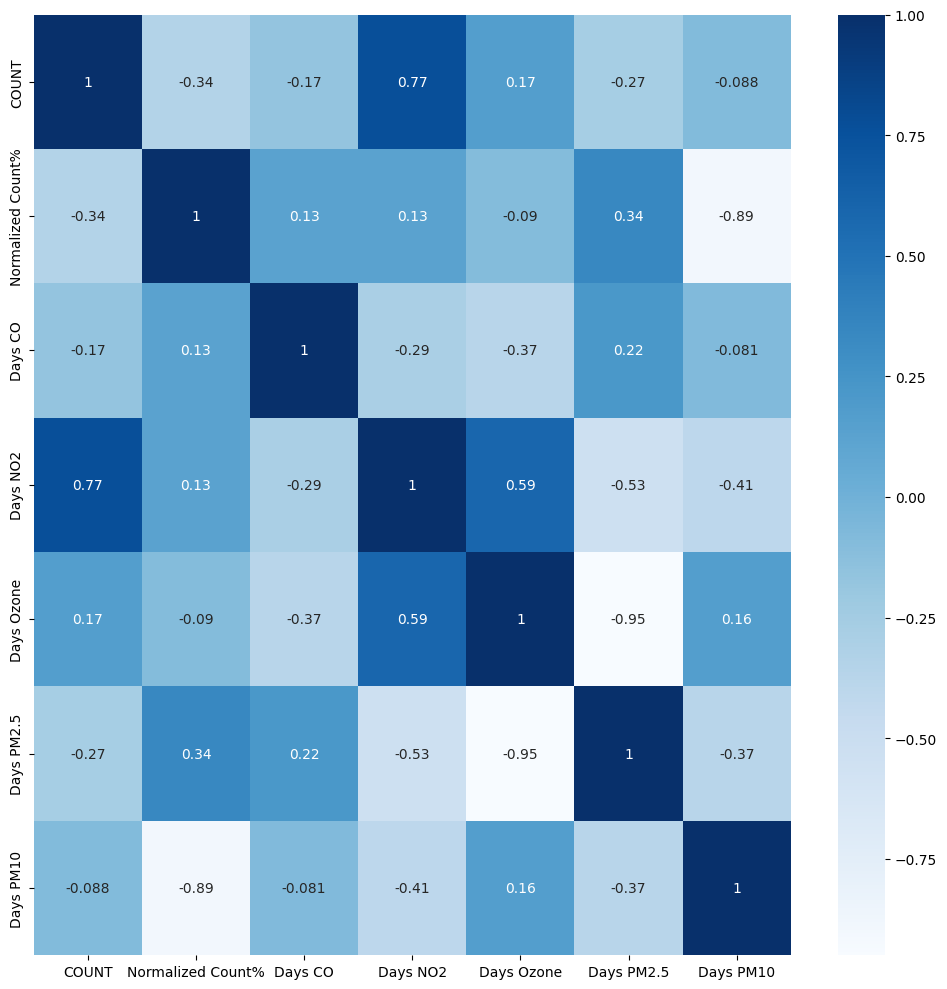

New England


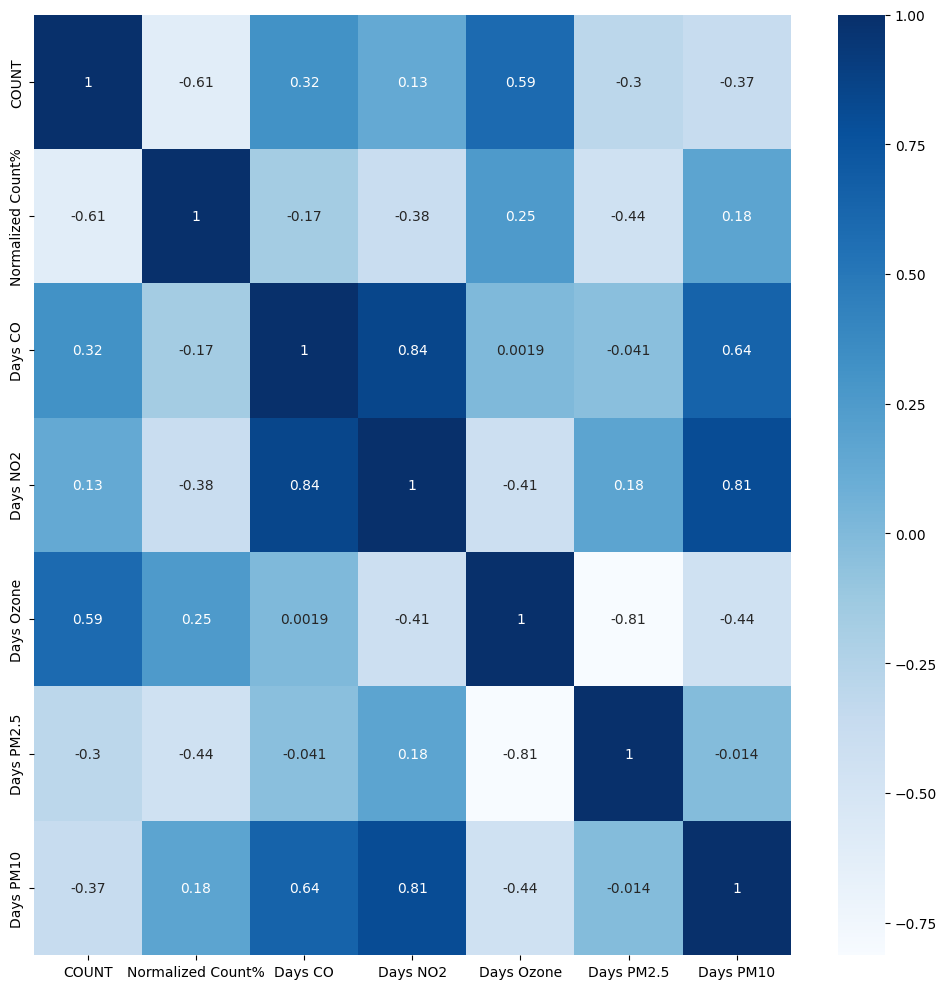

Mid-Atlantic


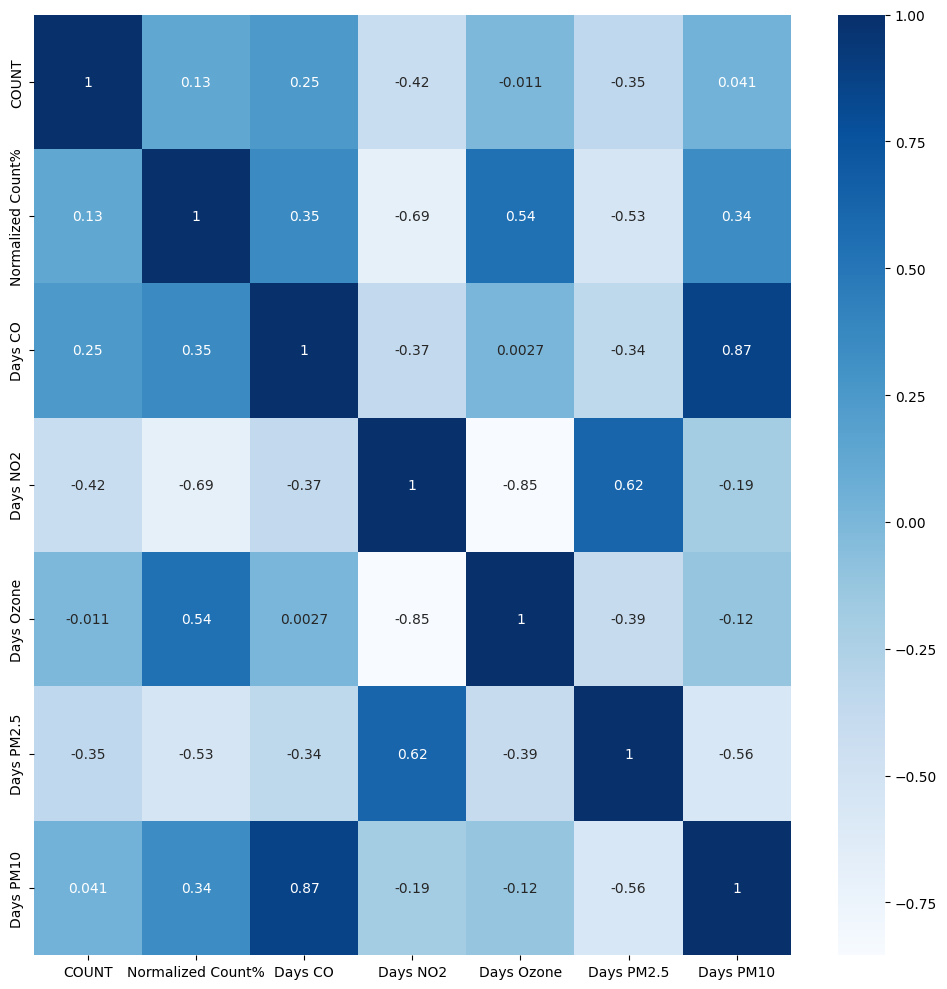

Midwest


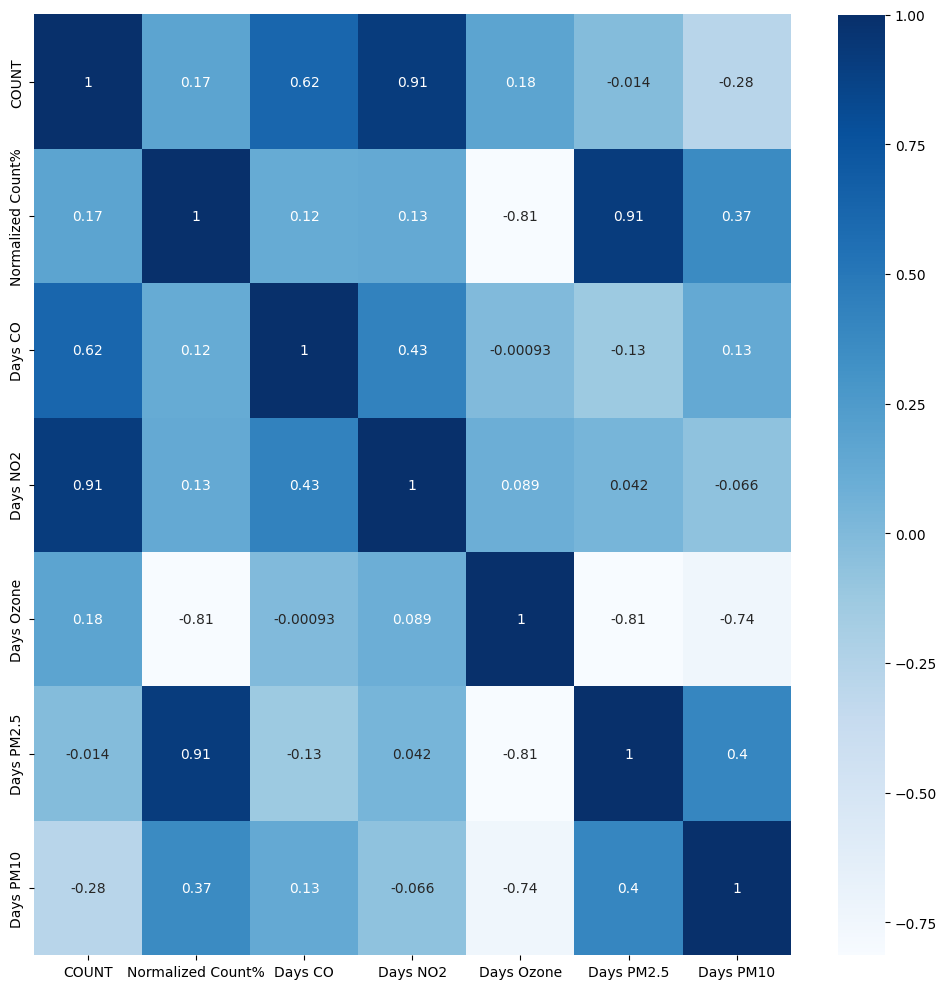

Great Plains


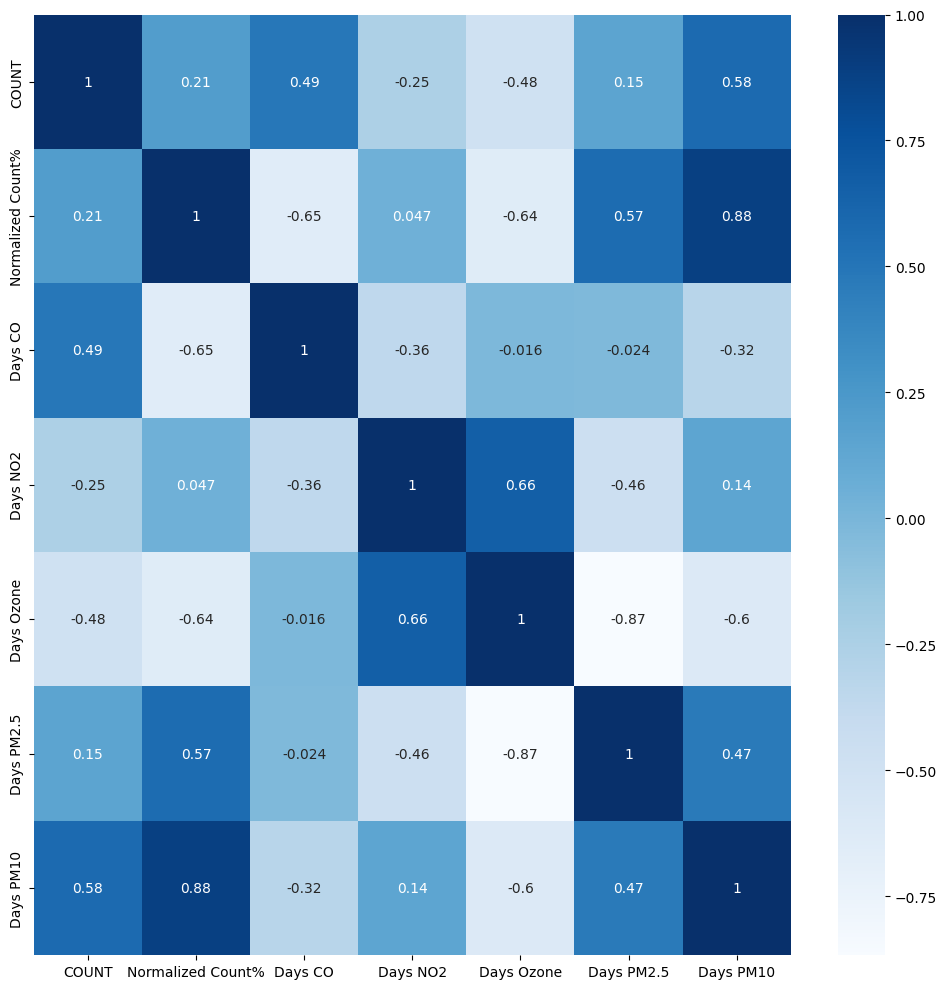

In [70]:
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution = '/kaggle/input/annual-aqi-by-county-2019/annual_aqi_by_county_2019.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2019'
#site_csv = 'df_cancer_airpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000

##########################################################

########################################################
#STEP 1 - Create Air pollution dataset for USA states
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new)

########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']
df_all = pd.merge(df_cancer_population_count, air_pollution_df_new, on='AREA', how='inner')

########################################################
#STEP 5 - Check for correlation across USA
##########################################################
# df_region_cancer = df_all.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
# print(df_region_cancer.columns)
# matrix_normalized_test = df_region_cancer.corr()
# plt.rcParams["figure.figsize"] = [15, 25]
# plt.rcParams["figure.autolayout"] = True
# fig, (ax1) = plt.subplots(ncols=1)
# fig.subplots_adjust(wspace=0.05)
# sns.heatmap(matrix_normalized_test, cmap="Greens", ax=ax1, cbar=True, annot=True)
# ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
# ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
# fig.subplots_adjust(wspace=0.005)
# plt.show()

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
print(df_cancercount_region)

########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
# regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
# for region in regions:
#     #---Consider region create corelation matrix ----
#     df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
#     #print (df_region.columns)
#     print (region)
#     df_region_cancer = df_region.iloc[:, [1,3,4,5,6, 7,8,9,10,11,12,13,14]]
#     #print(df_region_cancer.columns)
#     matrix_normalized_test = df_region_cancer.corr()
#     plt.rcParams["figure.figsize"] = [15, 25]
#     plt.rcParams["figure.autolayout"] = True
#     fig, (ax1) = plt.subplots(ncols=1)
#     fig.subplots_adjust(wspace=0.05)
#     sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
#     ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
#     ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
#     fig.subplots_adjust(wspace=0.005)
#     plt.show(fontsize=10)
    
########################################################
#STEP 7 - Check for correlation across different regions
##########################################################
regions = ["South","Alaska and Hawaii", "Southwest", "West Coast", "Rocky Mountains", "New England", "Mid-Atlantic", "Midwest", "Great Plains"]
for region in regions:
    #---Consider region create corelation matrix ----
    df_region = df_cancercount_region.loc[(df_cancercount_region['Region '] == region)] 
    #print (df_region.columns)
    print (region)
    df_region_cancer = df_region.iloc[:, [1,3,10,11,12,13,14]]
    #print(df_region_cancer.columns)
    matrix_normalized_test = df_region_cancer.corr()
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1) = plt.subplots(ncols=1)
    fig.subplots_adjust(wspace=0.05)
    sns.heatmap(matrix_normalized_test, cmap="Blues", ax=ax1, cbar=True, annot=True)
    #ax1.set_xticklabels(matrix_normalized_test.index, rotation=45)
    #ax1.set_yticklabels(matrix_normalized_test.index, rotation=45)
    fig.subplots_adjust(wspace=0.005)
    plt.show()

Index(['Great Plains', 'Mid-Atlantic', 'Midwest', 'New England',
       'Rocky Mountains', 'South', 'Southwest', 'West Coast'],
      dtype='object', name='Region ')
Index(['COUNT', 'Normalized Count%', 'Days CO', 'Days NO2', 'Days Ozone',
       'Days PM2.5', 'Days PM10'],
      dtype='object')


Text(0, 0.5, 'Days PM10')

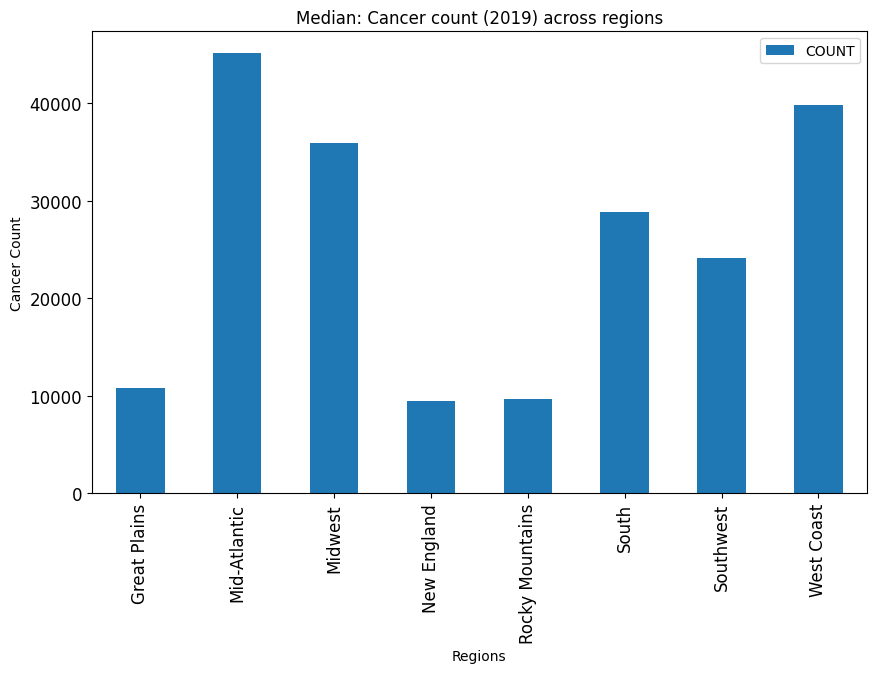

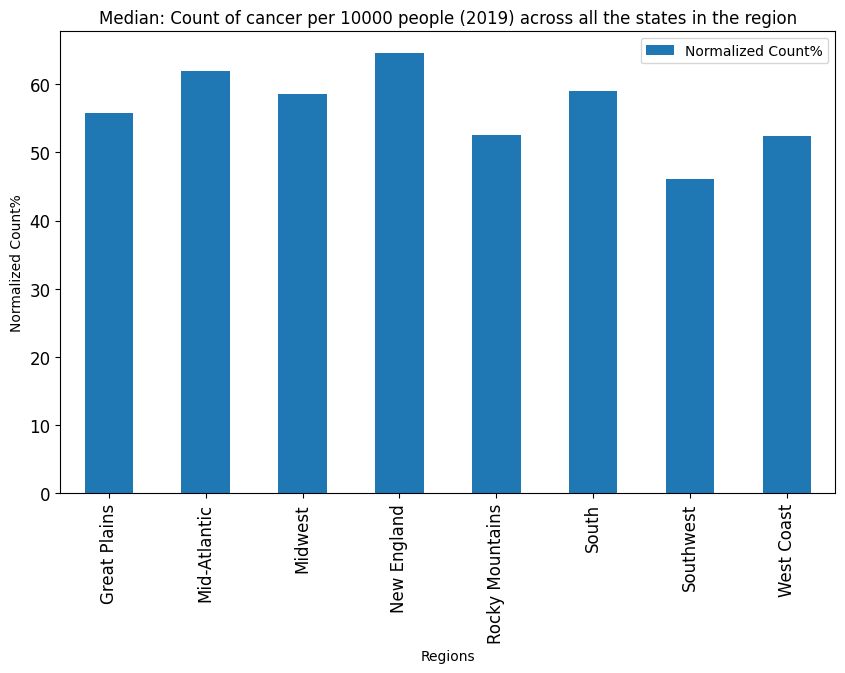

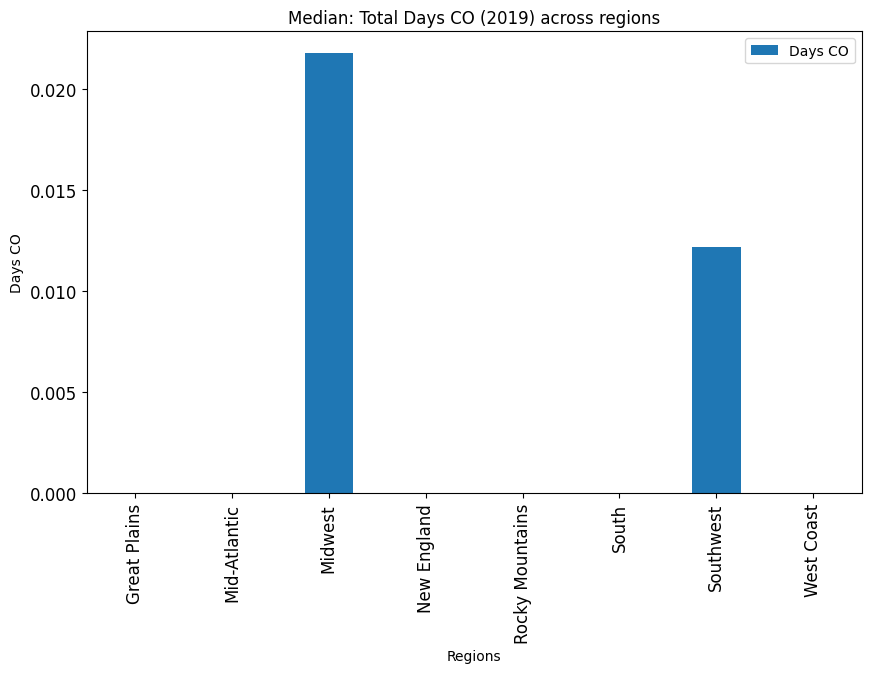

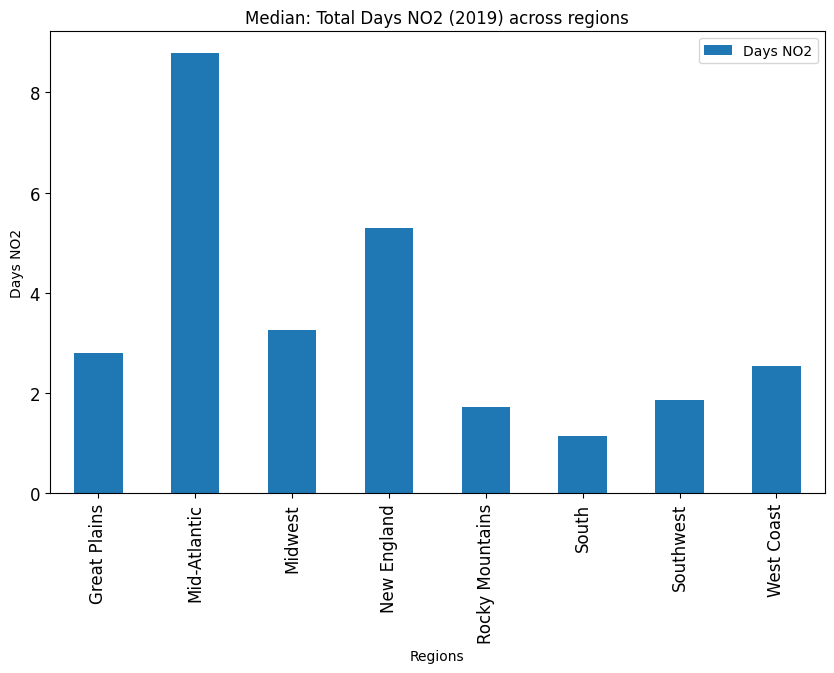

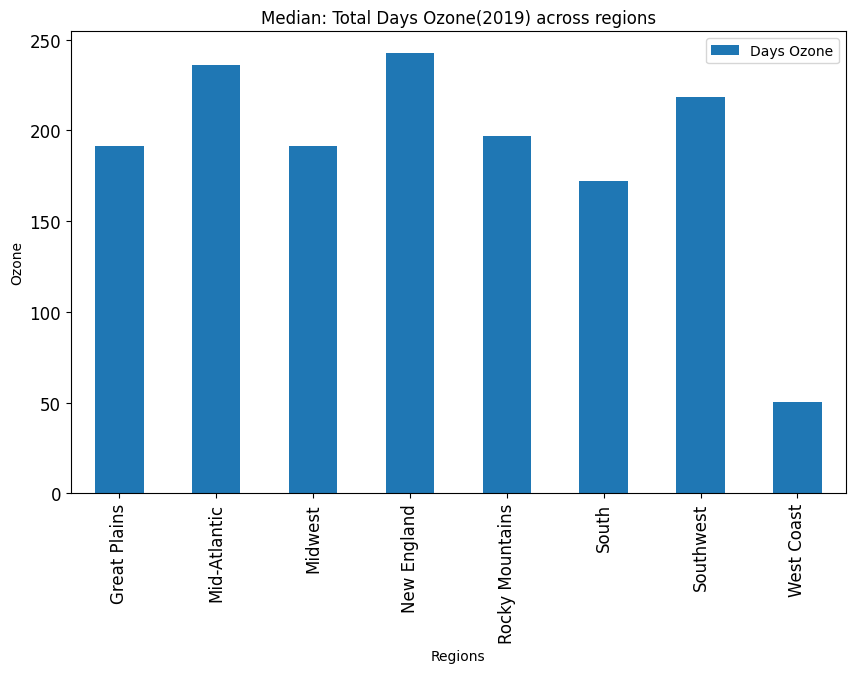

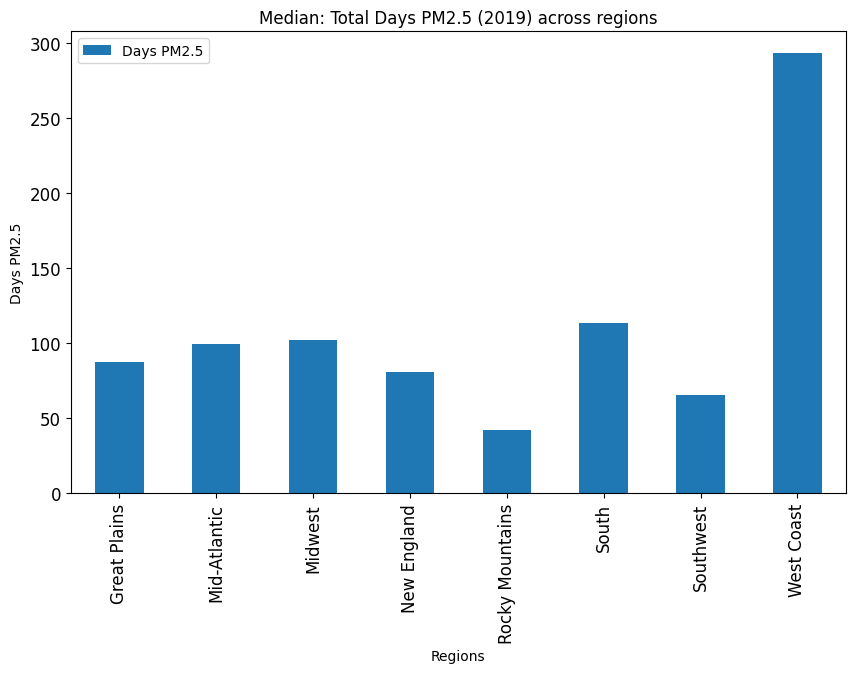

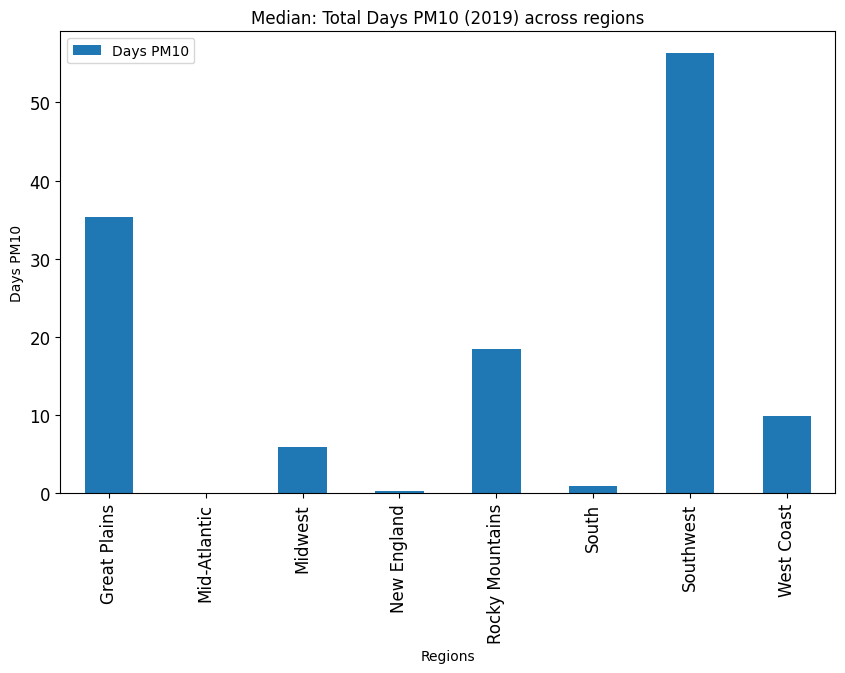

In [7]:
#Plotting graphs - Overall 2019 Vs Air pollutants

#importing modules
import pandas as pd
import csv
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION, #year = '2019', #site = 'all'
data_path_regional = '/kaggle/input/regional-dataset-2019-cancer-airpollution/regional_air_pollution_cancer_data_2019.csv'

########################################################
#STEP 1 - Diagram 1: Total Cancer across regions
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_all = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_regional))))

#get required columns
df = df_all.iloc[:, [2, 4,11, 12, 13, 14, 15, 16]]
df['COUNT']= df['COUNT'].astype(float)
df['Normalized Count%']= df['Normalized Count%'].astype(float)
df['Days CO']= df['Days CO'].astype(float)
df['Days NO2']= df['Days NO2'].astype(float)
df['Days Ozone']= df['Days Ozone'].astype(float)
df['Days PM2.5']= df['Days PM2.5'].astype(float)
df['Days PM10']= df['Days PM10'].astype(float)
#print(df.columns)

#change all the rows with region = 'New England ' to region = 'New England'
df['Region '] = df['Region '].replace('New England ', 'New England')
#print (df)

#remove Alaska and Hawaii region as they are single regions far apart and cannot be considered as clusters for corelation
df_new = df.loc[(df['Region '] != 'Alaska and Hawaii')] 

df_final =  df_new.groupby(['Region ']).median()
print(df_final.index)
print(df_final.columns)
#print(df_final)

#Diagram 1 - Regions Vs total Cancer count
ax = df_final[['COUNT']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Cancer count (2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Cancer Count")

#Diagram 2 - Regions Vs Normalized Cancer count
ax = df_final[['Normalized Count%']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Count of cancer per 10000 people (2019) across all the states in the region')
ax.set_xlabel("Regions")
ax.set_ylabel("Normalized Count%")

#Diagram 3 - Regions Vs Total Days CO
ax = df_final[['Days CO']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Total Days CO (2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Days CO")

#Diagram 4 - Regions Vs Total Days NO2
ax = df_final[['Days NO2']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Total Days NO2 (2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Days NO2")

#Diagram 5 - Regions Vs Total Days Ozone
ax = df_final[['Days Ozone']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Total Days Ozone(2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Ozone")

#Diagram 6 - Regions Vs Total Days PM2.5
ax = df_final[['Days PM2.5']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Total Days PM2.5 (2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Days PM2.5")

#Diagram 7 - Regions Vs Total Days PM10
ax = df_final[['Days PM10']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Total Days PM10 (2019) across regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Days PM10")



In [ ]:
#Create datasets for plotting graphs for paper - 2019  Melanomas of the Skin cancer and all air pollution types

#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution = '/kaggle/input/annual-aqi-by-county-2019/annual_aqi_by_county_2019.csv'
data_path_cancercount = '/kaggle/input/cancer-by-area/BYAREA.csv.TXT'
data_path_differentRegions = '/kaggle/input/regions-to-state-mapping-usa/DifferentRegionsUSA.csv'
data_path_allsites = '/kaggle/input/all-cancer-sites/sites.csv'

year = '2019'
#site_csv = 'df_cancer_airpollution-Esophagus.csv' #UNCOMMMENT IF YOU WANT DUMP DATA FOR ANALYSIS - step 5

#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000

##########################################################

########################################################
#STEP 1 - Create Air pollution dataset for USA states
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new)

########################################################
#STEP 2 - Create Cancer count dataset for USA states
##########################################################
#create dataframe
df_cc = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_cancercount))))

#Splitting the data into columns
df_new = df_cc.iloc[:, [0]]
df_new[['AREA','AGE_ADJUSTED_CI_LOWER', 'AGE_ADJUSTED_CI_UPPER','AGE_ADJUSTED_RATE','COUNT','EVENT_TYPE','POPULATION','RACE','SEX','SITE','YEAR','CRUDE_CI_LOWER','CRUDE_CI_UPPER','CRUDE_RATE']] = df_new['AREA|AGE_ADJUSTED_CI_LOWER|AGE_ADJUSTED_CI_UPPER|AGE_ADJUSTED_RATE|COUNT|EVENT_TYPE|POPULATION|RACE|SEX|SITE|YEAR|CRUDE_CI_LOWER|CRUDE_CI_UPPER|CRUDE_RATE'].str.split('|', expand=True)

#Clean the data to remove the rows where the values are not integers
if (site == 'all'):
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == 'All Cancer Sites Combined') & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 
else:
    df_new = df_new.loc[(df_new['YEAR'] == year) & (df_new['RACE'] == 'All Races') & (df_new['SEX'] == 'Male and Female') & (df_new['SITE'] == site) & (df_new['EVENT_TYPE'] != 'Mortality') & (df_new['COUNT'] != '~') & (df_new['COUNT'] != '+') & (df_new['COUNT'] != '-') &  (df_new['AREA'] != 'United States (comparable to ICD-O-2)') ] 

# #Seleting the columns needed
cancer_area = df_new.iloc[:, [1,5]]

# #Converting column to integer
#print(len(df_new))
cancer_area['COUNT'] = cancer_area['COUNT'].astype('int')
#print(cancer_area) 

########################################################
#STEP 3 - Create dataset population per state
##########################################################
#Selecting the columns needed
cancer_area_population = df_new.iloc[:, [1,7]]

#Converting column to integer
cancer_area_population['POPULATION'] = cancer_area_population['POPULATION'].astype('int')
cancer_area_population = cancer_area_population.groupby(['AREA'], as_index=False).max()

########################################################
#STEP 4 - Merge datasets cancer_area_pollution, cancer_count, air_pollution_df_new
##########################################################
df_cancer_population_count = pd.merge(cancer_area, cancer_area_population, on='AREA', how='outer')

#Create additional column in the table for (Count/Population * 10000)
df_cancer_population_count['COUNT'] = df_cancer_population_count['COUNT'].astype('int')
df_cancer_population_count['POPULATION'] = df_cancer_population_count['POPULATION'].astype('int')
df_cancer_population_count['Normalized Count%'] = df_cancer_population_count['COUNT'] * 10000 / df_cancer_population_count['POPULATION']
df_all = pd.merge(df_cancer_population_count, air_pollution_df_new, on='AREA', how='inner')

########################################################
#STEP 6 - Add in different regions to meged table
##########################################################
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_differentRegions))))
df_cancercount_region = pd.merge(df_all, df_ap, on='AREA', how='outer' )
print(df_cancercount_region.columns)
print(df_cancercount_region.head(1))

df_cancercount_region.to_csv('regional_air_pollution_MelanomasSkin_cancer_data_2019.csv')

Text(0, 0.5, 'Days PM2.5 at 50 & 90 percentiles across all the states in the region')

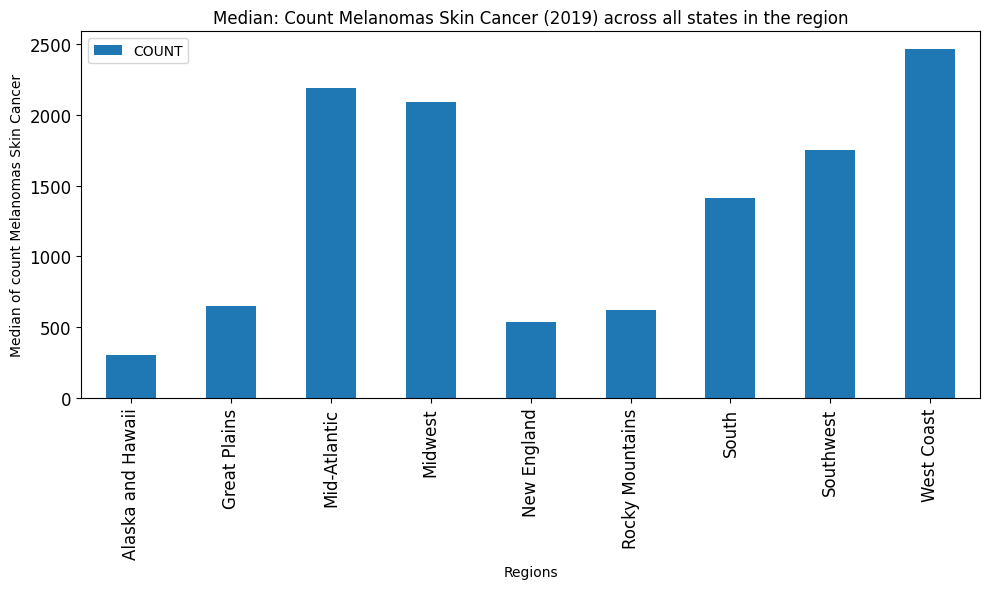

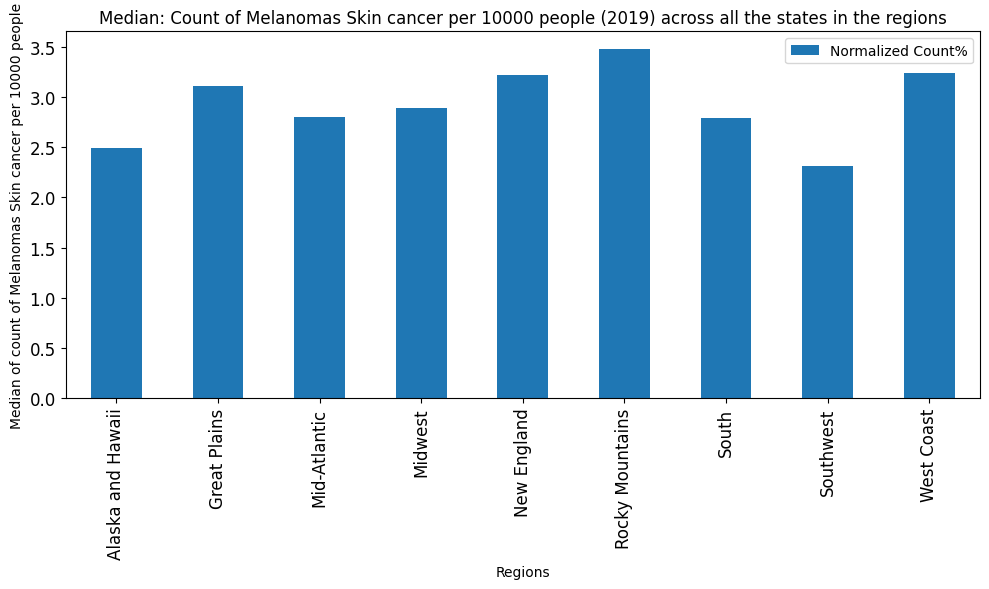

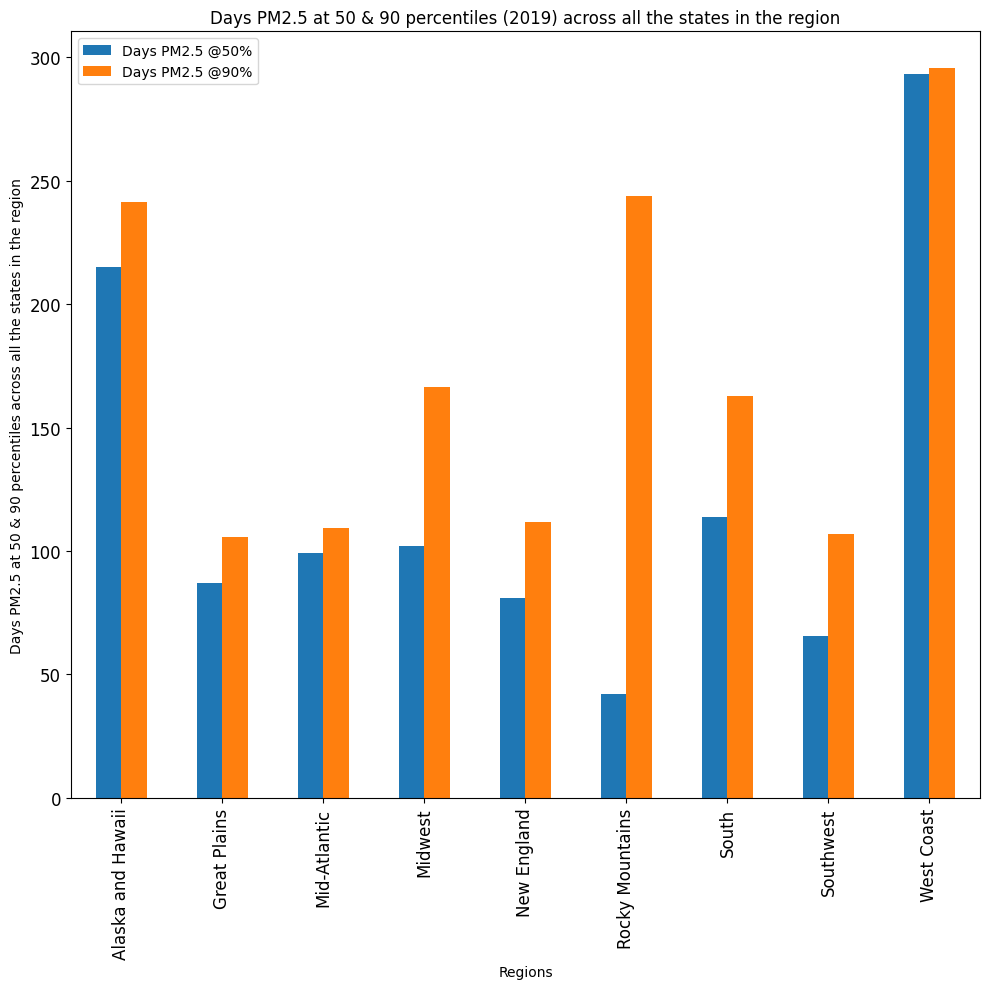

In [95]:
#Plotting graphs - Overall 2019 melonas of skin Vs Air pollutants

#importing modules
import pandas as pd
import csv
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION, #year = '2019', #site = 'Melanomas of the Skin'
data_path_regional = '/kaggle/input/reginonal-dataset-melonasofskin-airpollution/regional_air_pollution_MelonasOfSkin_data_2019.csv'

########################################################
#STEP 1 - Diagram 1: Total Cancer across regions
##########################################################
#remove warnings
pd.set_option('mode.chained_assignment', None)

#converting into dataframe
df_all = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_regional))))

#get required columns
df = df_all.iloc[:, [2, 4,11, 12, 13, 14, 15, 16]]
df['COUNT']= df['COUNT'].astype(float)
df['Normalized Count%']= df['Normalized Count%'].astype(float)
df['Days CO']= df['Days CO'].astype(float)
df['Days NO2']= df['Days NO2'].astype(float)
df['Days Ozone']= df['Days Ozone'].astype(float)
df['Days PM2.5']= df['Days PM2.5'].astype(float)
df['Days PM10']= df['Days PM10'].astype(float)
#print(df.columns)
#print(df['COUNT'].sum())

#change all the rows with region = 'New England ' to region = 'New England'
df['Region '] = df['Region '].replace('New England ', 'New England')

df_new =  df.groupby(['Region ']).median() 
#print(df_new)
#print(df_new.index)
#print(df_new.columns)
#print(df_new)

#Diagram 1 - Regions Vs total Cancer count
ax = df_new[['COUNT']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Count Melanomas Skin Cancer (2019) across all states in the region')
ax.set_xlabel("Regions")
ax.set_ylabel("Median of count Melanomas Skin Cancer")

#Diagram 2 - Regions Vs Normalized Cancer count
ax = df_new[['Normalized Count%']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Median: Count of Melanomas Skin cancer per 10000 people (2019) across all the states in the regions')
ax.set_xlabel("Regions")
ax.set_ylabel("Median of count of Melanomas Skin cancer per 10000 people")

# #Diagram 6 - Regions Vs Total Days PM2.5
# ax = df_new[['Days PM2.5']].plot(kind='bar',figsize=(10,6), fontsize=12, title='Total Days PM2.5 (2019) across regions')
# ax.set_xlabel("Regions")
# ax.set_ylabel("Days PM2.5")

df_new_90 = df.groupby(['Region ']).quantile(0.9) 
df_new.rename(columns = {'Normalized Count%':'Count per 10000 people @50%'}, inplace=True)
df_new.rename(columns = {'Days PM2.5':'Days PM2.5 @50%'}, inplace=True)
df_new_90.rename(columns = {'Normalized Count%':'Count per 10000 people @90%'}, inplace=True)
df_new_90.rename(columns = {'Days PM2.5':'Days PM2.5 @90%'}, inplace=True)

df_merge = pd.merge(df_new, df_new_90, on='Region ', how='outer')
#print (df_merge.columns)
df_final = df_merge.iloc [:, [5,12]]
#print (df_final)

#ax_new = df_new['Count per 10000 people @50%', 'Count per 10000 people @90%'].plot(kind='bar',figsize=(10,6), fontsize=12, title='PM2.5 (2019) across regions')
ax = df_final.plot.bar(fontsize=12, title='Days PM2.5 at 50 & 90 percentiles (2019) across all the states in the region')
ax.set_xlabel("Regions")
ax.set_ylabel("Days PM2.5 at 50 & 90 percentiles across all the states in the region")
                       
#df_new.to_csv('regional_SkinCancer_50.csv')
#df_new_90.to_csv('regional_SkinCancer_100.csv')


In [62]:
####################Trash########################
#importing modules
import pandas as pd
import csv
import seaborn as sns 
import matplotlib.pyplot as plt

#Setting the path and loading file - NEED TO CHANGE PER COMBINATION
data_path_airpollution_2019 = '/kaggle/input/annual-aqi-by-county-2019/annual_aqi_by_county_2019.csv'
data_path_airpollution_2018 = '/kaggle/input/annual-aqi-by-county-2018/annual_aqi_by_county_2018.csv'
data_path_airpollution_2020 = '/kaggle/input/annual-aqi-by-county-2020/annual_aqi_by_county_2020.csv'

#----------------------Year 2019----------------------
#Choose this if you want specififc Cancer Type
site = 'Melanomas of the Skin'
num1 = 0
num2 = 1000

#Choose this is if you want overall Cancer Types
# site = 'all'
# num1 = 0
# num2 = 1000
#remove warnings
pd.set_option('mode.chained_assignment', None)

#Variables that needs to be change 'year' and 'df_ap'
########################################################
#STEP 1 - Create Air pollution dataset for USA states - 2019
##########################################################
year = '2019'
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution_2019))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
#print(air_pollution_df_new['Days PM2.5'].sum())
#print(air_pollution_df_new['Days PM10'].sum())
TotalAirPollution_PM25_2019 = air_pollution_df_new['Days PM2.5'].sum()

########################################################
#STEP 2 - Create Air pollution dataset for USA states - 2018
##########################################################
year = '2018'
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution_2018))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
TotalAirPollution_PM25_2018 = air_pollution_df_new['Days PM2.5'].sum()


########################################################
#STEP 2 - Create Air pollution dataset for USA states - 2020
##########################################################
year = '2020'
df_ap = pd.DataFrame.from_dict(list(csv.DictReader(open(data_path_airpollution_2020))))

#get required columns
air_pollution_df = df_ap.iloc[:, [0,5,6,7,8,9,10,13,14,15,16,17]]

#Make the columns into int
air_pollution_df['Moderate Days'] = air_pollution_df['Moderate Days'].astype('int')
air_pollution_df['Unhealthy for Sensitive Groups Days'] = air_pollution_df['Unhealthy for Sensitive Groups Days'].astype('int')
air_pollution_df['Unhealthy Days'] = air_pollution_df['Unhealthy Days'].astype('int')
air_pollution_df['Very Unhealthy Days'] = air_pollution_df['Very Unhealthy Days'].astype('int')
air_pollution_df['Hazardous Days'] = air_pollution_df['Hazardous Days'].astype('int')
air_pollution_df['Max AQI'] = air_pollution_df['Max AQI'].astype('int')
air_pollution_df['Days CO'] = air_pollution_df['Days CO'].astype('int')
air_pollution_df['Days NO2'] = air_pollution_df['Days NO2'].astype('int')
air_pollution_df['Days Ozone'] = air_pollution_df['Days Ozone'].astype('int')
air_pollution_df['Days PM2.5'] = air_pollution_df['Days PM2.5'].astype('int')
air_pollution_df['Days PM10'] = air_pollution_df['Days PM10'].astype('int')
air_pollution_df.rename(columns = {'State':'AREA'}, inplace=True)

#Clean the data to remove the rows where the values are not integers
df_new_ap = air_pollution_df.loc[(air_pollution_df['AREA'] != 'Country Of Mexico') & (air_pollution_df['AREA'] != 'Virgin Islands') & (air_pollution_df['AREA'] != 'Puerto Rico')] 
df_new_ap.set_index('AREA', inplace = True)
df_new_ap.rename(index={'District Of Columbia': 'District of Columbia'}, inplace=True)
air_pollution_df_new =  df_new_ap.groupby(['AREA']).mean() 
TotalAirPollution_PM25_2020  = air_pollution_df_new['Days PM2.5'].sum()

################
print(TotalAirPollution_PM25_2018)
print(TotalAirPollution_PM25_2019)
print(TotalAirPollution_PM25_2020)


6152.852998071596
5817.631591714414
6179.546898065878
